# Imports

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy.random import normal, uniform, shuffle

# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, auc
from sklearn.ensemble import RandomForestRegressor

import dill
# import datetime

import itertools

In [2]:
%matplotlib inline

In [ ]:
# dill.dump_session('cache/Reduced_model.db')

In [3]:
dill.load_session('cache/Reduced_model.db')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# data_path = 'drive/My Drive/Colab Notebooks/NIR/data/'

In [4]:
data_path = 'data/prepared/'

In [5]:
results_path = 'vector/results_LD_SD/Reduced_model/'

# Data reading

## Reading

### Synth data for model building

In [5]:
X_train = pd.read_csv(data_path + 'X_train.csv')
X_test = pd.read_csv(data_path + 'X_test.csv')

Y_train = pd.read_csv(data_path + 'y_train.csv')
Y_test = pd.read_csv(data_path + 'y_test.csv')

### Real data for analysis

In [6]:
conditions = ['LD', 'SD']

In [7]:
X_real = {}
Y_real = {}
for cond in conditions:
    X_real[cond] = pd.read_csv(data_path + 'real_X_' + cond + '.csv')
    Y_real[cond] = pd.read_csv(data_path + 'real_Y_' + cond + '.csv')

In [8]:
X_real['LD']

AP1     FD  FTa1  FTa2  FTa3  FTb  FTc    LFY   TFL1a   TFL1c  days
0     2  31.53     2     8   0.9    3    0    6.4  22.021  25.556     9
1     0  47.62     0    11   0.5    7    0   12.1  20.489  25.263    11
2     6  45.41     1    29   0.8    6    0   21.4  27.397  32.982    13
3     5  40.89     5    60  10.2   28    0   56.8  33.074  39.708    15
4    23  79.47     9    50   1.3   12    0   77.1  42.561  32.222    17
5    33  71.69    40    86   2.5   58    0   48.9  54.798  67.895    20
6     1  25.86    10    18   3.4    7    0   16.0   8.314  11.930    22
7    92  43.31    10    68   4.7  127    0   45.1  18.325  25.731    25
8    19  45.20    10    37   2.1   61    0   27.7  15.851  18.713    28
9   355  81.78     6    52  14.8  102   14   50.9  22.232  29.766    30
10  117  36.26     1    16   3.0   13    0   63.7  11.323  15.029    32
11  649  63.59    29    62  90.4  140    0  124.2  24.033  31.462    34
12  691  81.78     6    34   6.8   25    0  126.1  15.465  19.240    37

In [9]:
Y_real['LD']['days'] = X_real['LD'].days.tolist()[1:] + [40]
Y_real['SD']['days'] = X_real['SD'].days.tolist()[1:] + [34]

### STDs

In [6]:
stds = {}
for cond in conditions:
    stds[cond] = pd.read_csv(data_path + f'stds_{cond}.csv')
    stds[cond] = stds[cond].drop(0)
    stds[cond] = stds[cond].drop(FTs, axis = 1)

## Check the data

In [10]:
X_train.tail()

AP1         FD        FTa1        FTa2        FTa3         FTb  \
11245   588.991212  70.888154  103.077076   93.023388   70.782000   72.425457   
11246  1113.339109  56.924265   74.005610  118.649627   44.217579  104.180986   
11247   900.774255  54.069139   54.113466   96.036398   48.903466  171.118201   
11248   821.903720  63.723559   96.133299   65.631401  124.423143   22.528431   
11249   604.804570  93.748079   97.795785   71.113849  121.149614   13.193296   

             FTc         LFY      TFL1a      TFL1c  days  
11245  41.015956  100.779974  12.677451  20.201277    37  
11246  11.508512  139.423633  15.065515  20.493130    37  
11247  54.181371   92.847746  20.507869  15.904987    37  
11248  71.695521   95.888681  12.533753  17.714108    37  
11249  55.029060   94.574493  17.020120  21.581374    37

In [11]:
X_train.days.value_counts()

31    750
15    750
30    750
22    750
37    750
13    750
28    750
20    750
19    750
11    750
34    750
25    750
17    750
9     750
32    750
Name: days, dtype: int64

In [12]:
Y_train.tail()

AP1          FD         LFY      TFL1a      TFL1c  days
11245  1251.812881  167.213287   79.448156  18.298156  45.239936    40
11246  1194.070351   99.761610   60.205341  12.583602  59.752023    40
11247   114.166445  114.539155  115.570392  16.489382  52.343561    40
11248   948.621689  123.531040   77.978871  14.202135  36.274194    40
11249   784.562923  137.690553  104.025653  16.390520  76.987036    40

In [13]:
days = list(set(X_test.days.values))
days.append(40)
days.sort()
days

[9, 11, 13, 15, 17, 19, 20, 22, 25, 28, 30, 31, 32, 34, 37, 40]

In [14]:
X = X_train.drop('days', axis=1)
Y = Y_train.drop('days', axis=1)

In [15]:
targets = Y.columns.tolist()
targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [16]:
X_test.tail()

AP1         FD       FTa1        FTa2        FTa3         FTb  \
3745  1152.078193  77.057377  82.118642   83.302730  118.042212  277.829939   
3746   284.410108  89.115439  74.729687  103.550847   74.380440  221.830060   
3747   752.961542  83.447183  70.001875  113.037540   79.050480  208.505822   
3748   772.521693  60.402778  71.593090  115.201894  190.275172  362.161735   
3749   796.368297  69.968481  20.206926   78.275921  194.341047  367.245787   

            FTc         LFY      TFL1a      TFL1c  days  
3745  78.337705  123.840171  15.150147  18.504293    37  
3746  36.183728    9.734097  18.057826  26.850785    37  
3747  14.881454   99.553233  16.537571  18.209133    37  
3748  79.106104   85.686811  20.053558  17.480942    37  
3749  84.502455  141.943119  14.251000  20.316351    37

# Random forest

In [17]:
genes = X_test.drop('days', axis = 1).columns.tolist()
targets = [name for name in genes if not name.startswith('FT')]
FTs = sorted(list(set(genes) - set(targets)))

In [18]:
regulators = {
    'AP1': genes[1:],
    'FD': ['LFY'],
    'LFY': genes.copy(),
    'TFL1a': ['AP1'],
    'TFL1c': ['AP1']
}

regulators['LFY'].remove('LFY')

## Model building

In [20]:
def GridS(model, grid, cv, **kwargs):
    return GridSearchCV(model, grid, 
                      n_jobs=-1, 
                      scoring=['neg_mean_squared_error', 'r2'], 
                      refit='neg_mean_squared_error', 
#                       scoring = MSE5,
#                       refit = MSE5,
                      cv=cv, 
                      verbose=10)

### Rough tuning

In [19]:
cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [20, 50, 100, 300],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_depth': [5, 8, 20, None]
}

In [21]:
model = {}
gs = {}

for t in targets:
    model[t] = RandomForestRegressor()
    gs[t] = GridS(model[t], grid, cv)

In [22]:
for t in targets:
    gs[t].fit(X[regulators[t]].values, Y[t].values)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1616s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0101s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   31.5s
[Parallel(n_jo

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1686s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0482s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   32.1s
[Parallel(n_jo

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1626s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0323s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   32.8s
[Parallel(n_jo

In [23]:
for t in targets:
    print(t , gs[t].best_params_)

AP1 {'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 300}
FD {'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 100}
LFY {'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 300}
TFL1a {'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 100}
TFL1c {'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 100}


In [25]:
best_model = {}

for t in targets:
    best_model[t] = gs[t].best_estimator_

### Fine tuning (?)

In [ ]:
model = RandomForestRegressor()

cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [250, 300, 350],
    'min_samples_leaf': [5, 10, 15],
    'max_depth': [15, 20, 25, None]
}

In [ ]:
gs = GridS(model, grid, cv)

In [ ]:
gs.fit(X.values, Y.values)

In [ ]:
gs.best_params_

In [ ]:
gs.score

Get the model with best score on the cross-validation:

In [ ]:
best_model = gs.best_estimator_

### Save the model

In [26]:
with open('cache/Reduced_model.md', 'wb') as ouf:
    dill.dump(best_model, ouf)

## Make predictions

In [27]:
def predict(data):
    predictions = pd.DataFrame()
    
    for t in targets:
        predictions[t] = best_model[t].predict(data[regulators[t]].values)
        
    return predictions

In [29]:
predictions_train = predict(X)
predictions_test = predict(X_test.drop('days', axis=1))

## Evaluating

In [3]:
def print_scores(true_values, predictions):
    MSEs = mean_squared_error(true_values.values, predictions.values, multioutput='raw_values').round(2)
    NRMSE = (np.sqrt(MSEs) / np.amax(true_values, axis=0)).round(3)
    R2 = r2_score(true_values.values, predictions.values, multioutput='raw_values').round(2)
    r = [] 
    for i in range(len(targets)):
        r.append(np.corrcoef(true_values.values.transpose()[i], predictions.values.transpose()[i]).round(2)[0, 1])
    df = pd.DataFrame({'MSE': MSEs, 'NRMSE': NRMSE,'R2': R2, 'r': r}, index=targets)
    return df

In [6]:
def comparsion_plot(true_values, predictions, data_type = 'train', current_target=targets[0], s=3, format='svg'):
    plt.scatter(true_values, predictions, s=s)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r')
    plt.xlabel('True Values' + ' (' + current_target + ')')
    plt.ylabel('Predictions' + ' (' + current_target + ')')
    plt.axis('equal')
    plt.axis('square')
    plt.title('Predictions on ' + data_type)
    
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    plt.savefig(results_path + current_target + '_' + data_type + f'.{format}', bbox_inches='tight', format=format, dpi=300)
    plt.show()

Scores on train:  
(r - Pearson correlation)

In [4]:
print_scores(Y, predictions_train)

MSE  NRMSE    R2     r
AP1    11043.87  0.050  0.89  0.94
FD       561.70  0.141  0.20  0.44
LFY     1676.77  0.067  0.71  0.85
TFL1a    167.20  0.138  0.09  0.30
TFL1c    197.60  0.148  0.07  0.27

Scores on test:

In [5]:
print_scores(Y_test.drop('days', axis=1), predictions_test)

MSE  NRMSE    R2     r
AP1    16967.37  0.066  0.82  0.91
FD       546.03  0.145  0.20  0.44
LFY     2694.80  0.086  0.55  0.74
TFL1a    167.13  0.143  0.09  0.30
TFL1c    196.90  0.151  0.06  0.25

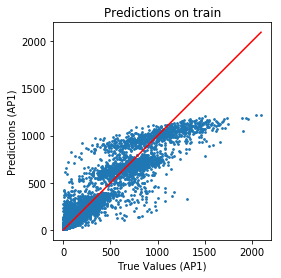

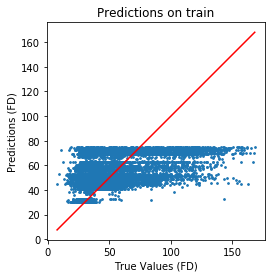

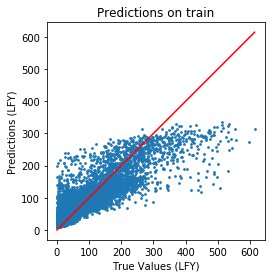

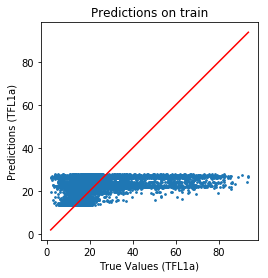

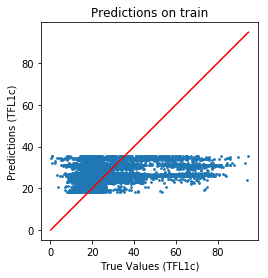

In [7]:
for i in range(5):
    comparsion_plot(Y.iloc[:, i], predictions_train.iloc[:, i], data_type='train', current_target=targets[i])

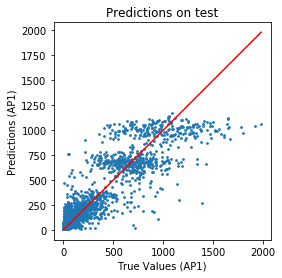

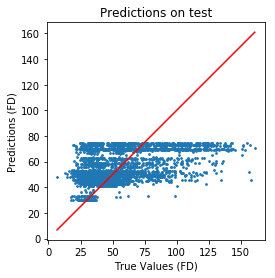

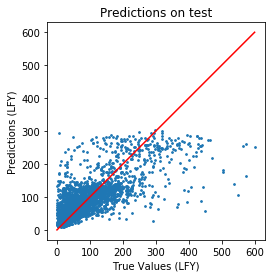

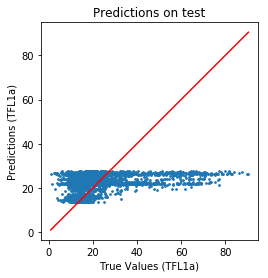

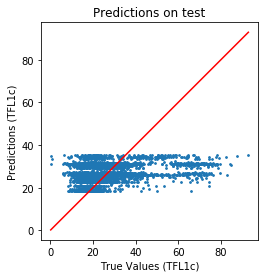

In [8]:
for i in range(5):
    comparsion_plot(Y_test.drop('days', axis=1).iloc[:, i], predictions_test.iloc[:, i], data_type='test', current_target=targets[i])

## Feature importances

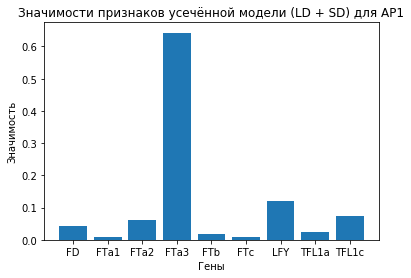

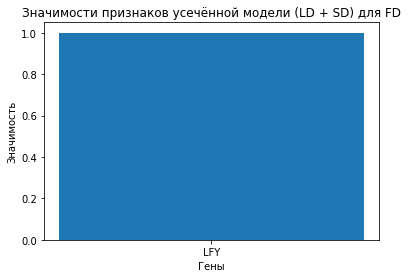

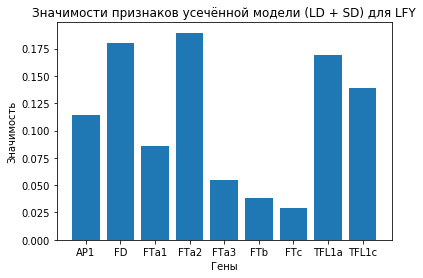

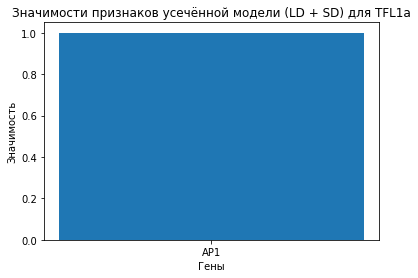

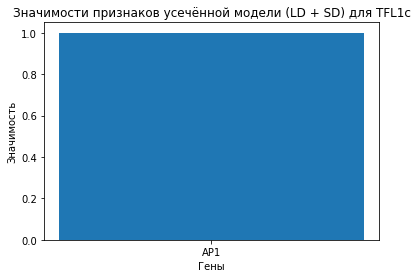

In [11]:
for t in targets:
    plt.bar(x = regulators[t], height = best_model[t].feature_importances_)
    plt.title(f'Значимости признаков усечённой модели (LD + SD) для {t}')
    plt.xlabel('Гены')
    plt.ylabel('Значимость')
    plt.savefig(results_path + f'/feature_importances/{t}_FI')
    plt.show()

# Real data

In [14]:
def time_long_plot(true_values, predicted, condition = 'LD', predict_method = 'static'):
    
    for i in range(5):
        
        plt.errorbar(true_values['days'], true_values.iloc[:,i], stds[condition].iloc[:,i],
                     marker='o', linestyle = '', capsize=3)
        
        plt.plot(true_values['days'], predicted.iloc[:, i].values, '-')
        
        plt.title(targets[i] + ' ' + condition + f' ({predict_method} prediction method)')
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['predictions', 'true values'])
        
        fig_path = results_path + predict_method + '/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + condition + f'/{targets[i]}_{condition}_pred_on_real.svg', 
                    bbox_inches='tight', format='svg')
        plt.show()

## Static

In [12]:
predictions_real = {}
predictions_real['LD'] = predict(X_real['LD'].drop('days', axis=1))
predictions_real['SD'] = predict(X_real['SD'].drop('days', axis=1))

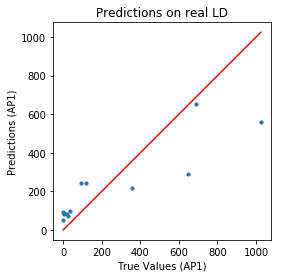

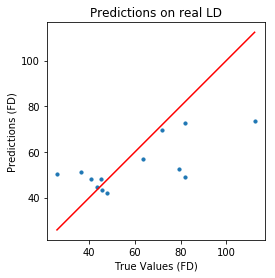

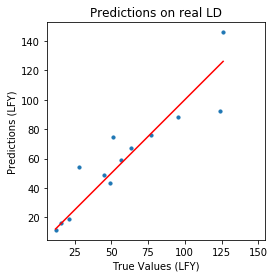

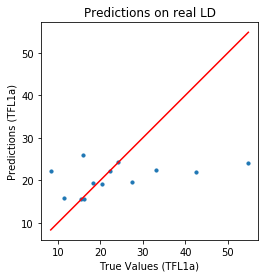

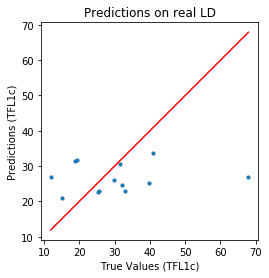

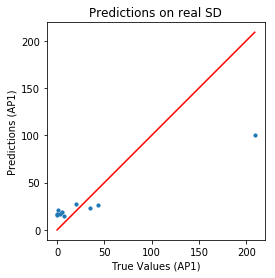

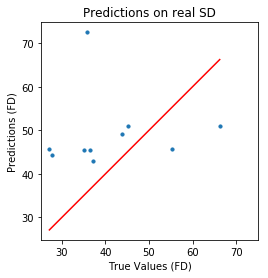

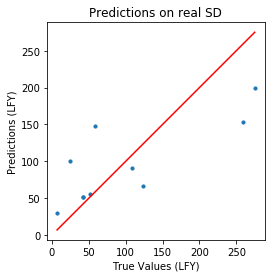

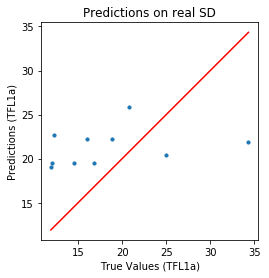

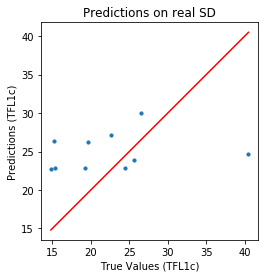

In [11]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real[cond].iloc[:, i], data_type='real ' + cond, current_target=targets[i], s=10)

In [44]:
for cond in conditions:
    print(cond)
    print(print_scores(Y_real[cond].drop('days', axis=1), predictions_real[cond]))

LD
            MSE    R2     r
AP1    33985.72  0.68  0.89
FD       334.36  0.39  0.73
LFY      217.68  0.84  0.92
TFL1a    143.99  0.08  0.42
TFL1c    209.46 -0.09  0.09
SD
           MSE    R2     r
AP1    1374.96  0.63  0.99
FD      258.78 -0.94  0.06
LFY    3510.89  0.57  0.78
TFL1a    49.80 -0.12  0.30
TFL1c    59.03 -0.10  0.19


In [7]:
print_scores(Y_real['LD'].drop('days', axis=1), predictions_real['LD'])

MSE  NRMSE    R2     r
AP1    33985.72  0.180  0.68  0.89
FD       334.36  0.163  0.39  0.73
LFY      217.68  0.117  0.84  0.92
TFL1a    143.99  0.219  0.08  0.42
TFL1c    209.46  0.213 -0.09  0.09

In [8]:
print_scores(Y_real['SD'].drop('days', axis=1), predictions_real['SD'])

MSE  NRMSE    R2     r
AP1    1374.96  0.177  0.63  0.99
FD      258.78  0.243 -0.94  0.06
LFY    3510.89  0.215  0.57  0.78
TFL1a    49.80  0.206 -0.12  0.30
TFL1c    59.03  0.190 -0.10  0.19

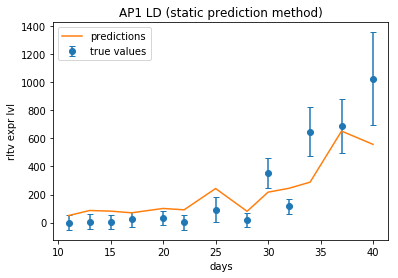

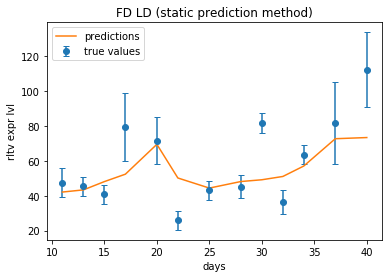

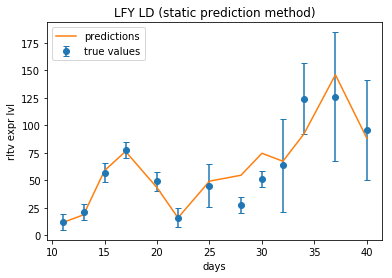

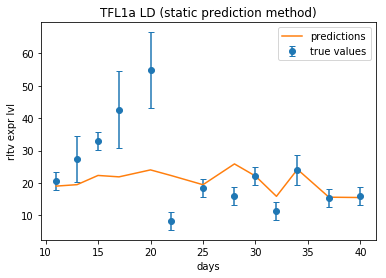

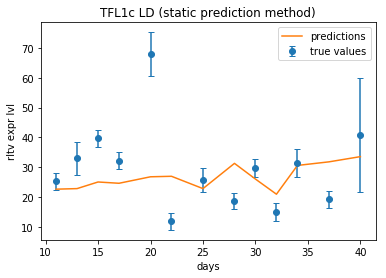

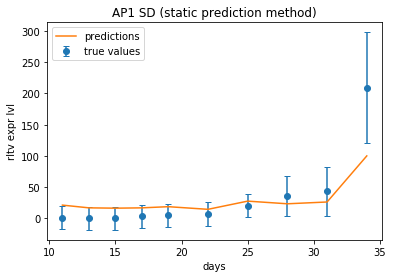

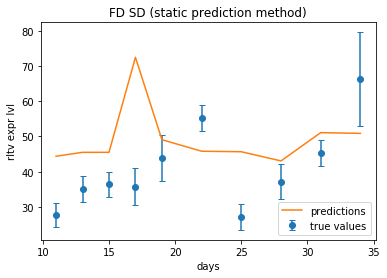

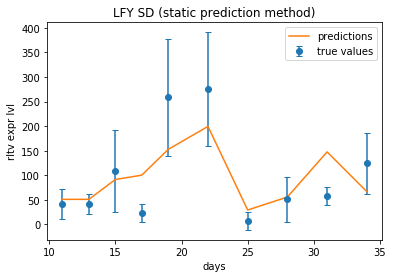

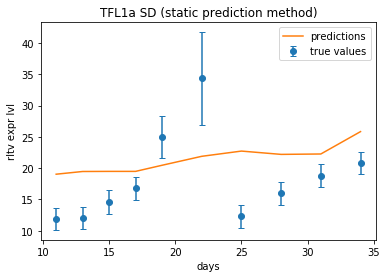

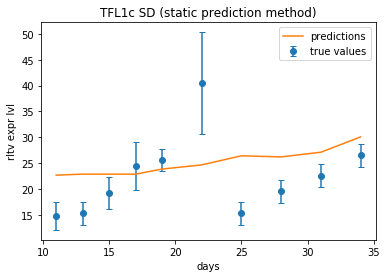

In [15]:
for cond in conditions:
    time_long_plot(Y_real[cond], predictions_real[cond], cond)

## Dynamic

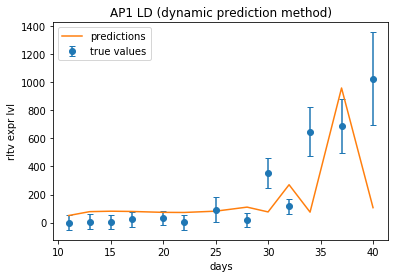

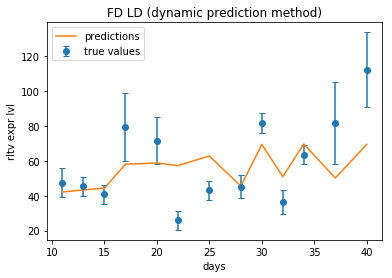

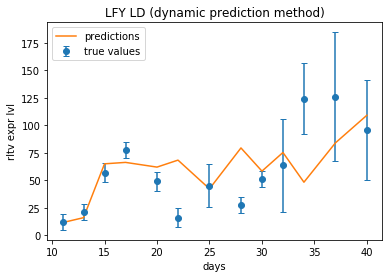

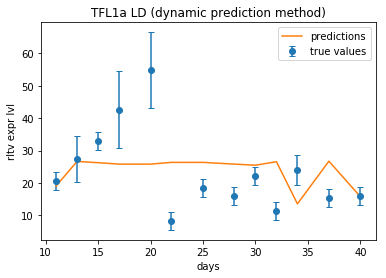

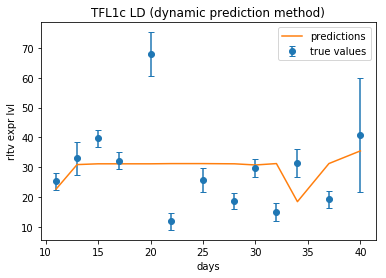

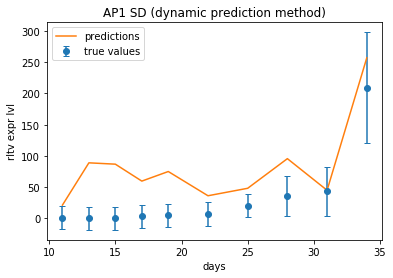

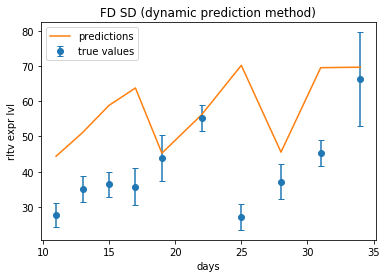

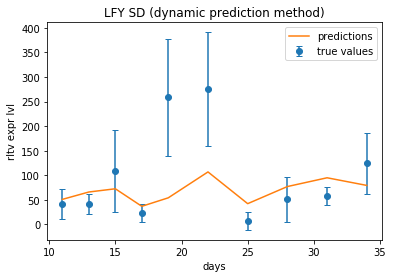

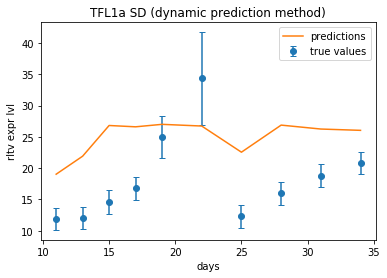

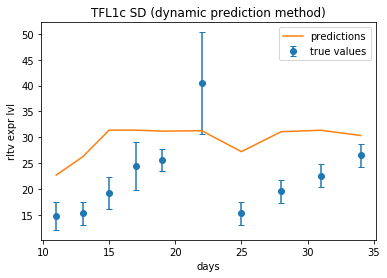

In [16]:
for cond in conditions:

    X_temp = X_real[cond].drop('days', axis = 1)

    predictions_real[cond] = pd.DataFrame(columns=targets)

    for i in X_real[cond].index:
        current_predictions = predict(X_temp.loc[[i]])
        predictions_real[cond] = predictions_real[cond].append(current_predictions, ignore_index = True)
        X_temp[targets] = current_predictions.values[0]

    time_long_plot(Y_real[cond], predictions_real[cond], cond, 'dynamic')

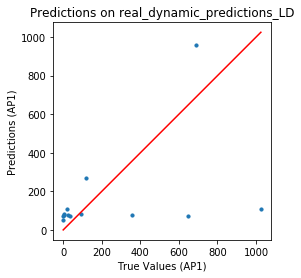

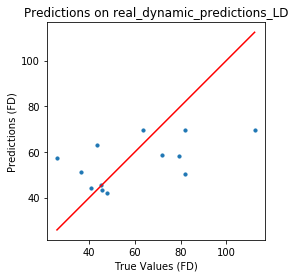

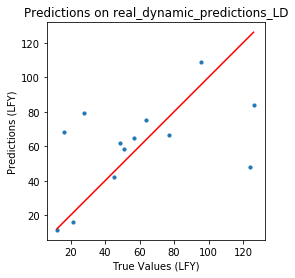

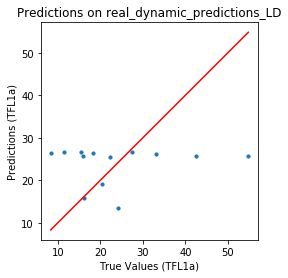

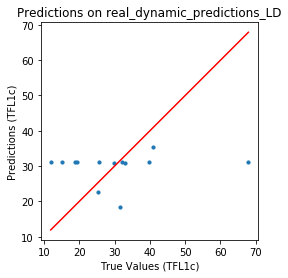

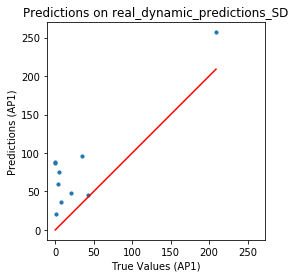

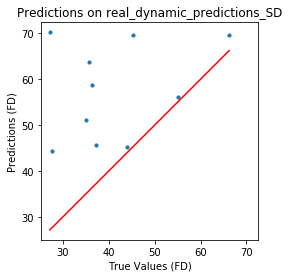

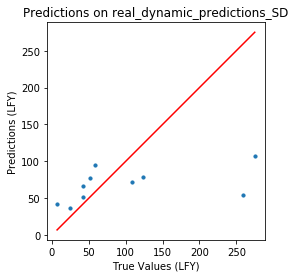

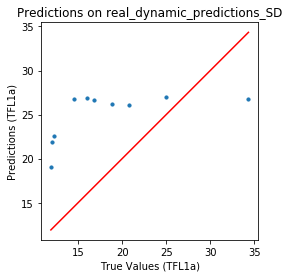

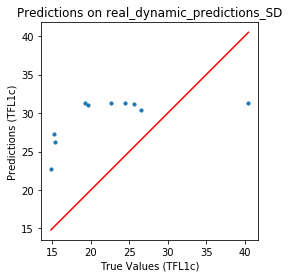

In [14]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real[cond].iloc[:, i], data_type='real_dynamic_predictions_' + cond, current_target=targets[i], s=10)

In [48]:
for cond in conditions:
    print(cond)
    print(print_scores(Y_real[cond].drop('days', axis=1), predictions_real[cond]))

LD
             MSE    R2     r
AP1    106093.63  0.01  0.40
FD        406.03  0.26  0.56
LFY      1054.89  0.21  0.50
TFL1a     164.46 -0.05  0.11
TFL1c     199.84 -0.04  0.09
SD
           MSE    R2     r
AP1    3154.43  0.14  0.90
FD      436.36 -2.27  0.30
LFY    7765.20  0.05  0.47
TFL1a    76.49 -0.71  0.58
TFL1c    85.81 -0.60  0.60


In [10]:
print_scores(Y_real['LD'].drop('days', axis=1), predictions_real['LD'])

MSE  NRMSE    R2     r
AP1    106093.63  0.318  0.01  0.40
FD        406.03  0.179  0.26  0.56
LFY      1054.89  0.258  0.21  0.50
TFL1a     164.46  0.234 -0.05  0.11
TFL1c     199.84  0.208 -0.04  0.09

In [11]:
print_scores(Y_real['SD'].drop('days', axis=1), predictions_real['SD'])

MSE  NRMSE    R2     r
AP1    3154.43  0.269  0.14  0.90
FD      436.36  0.315 -2.27  0.30
LFY    7765.20  0.320  0.05  0.47
TFL1a    76.49  0.255 -0.71  0.58
TFL1c    85.81  0.229 -0.60  0.60

# Knock out simulation

## Methods definitions

In [20]:
def time_long_plot_ko(true_values, predicted, pred_for_ko, KO_gene, condition, predict_method = 'dynamic', format='svg'):
    x_axis = true_values['days']
    
    for i in range(5):        
        plt.errorbar(true_values['days'], true_values.iloc[:,i], stds[condition].iloc[:,i],
                     marker='o', linestyle = '', capsize=3)
        
        plt.plot(x_axis, predicted.iloc[:, i], '--')
        plt.plot(x_axis, pred_for_ko.iloc[:, i], '-')
        
        if type(KO_gene) == type(''):
            KO_name = KO_gene
        else:            
            KO_name = '_'.join(KO_gene)

        plt.title(targets[i] + f' ({condition} with {KO_gene} KO)') # for correct title
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['true values', 'predictions on WT', 'predictions with KO'])
        
        if type(KO_gene) != type(''):
            KO_number = len(KO_gene)
        else:
            KO_number = 1
        
        fig_path = results_path + f'{predict_method}/KOs/{targets[i]}/{KO_number}/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{targets[i]}_{condition}_with_{KO_gene}_KO.svg', 
                    bbox_inches='tight', format = 'svg')
        plt.show()

## KO Iterations set

In [50]:
targets_with_cond = [name + '_LD' for name in targets]
targets_with_cond = targets_with_cond + [name + '_SD' for name in targets]

In [51]:
targets_with_cond

['AP1_LD',
 'FD_LD',
 'LFY_LD',
 'TFL1a_LD',
 'TFL1c_LD',
 'AP1_SD',
 'FD_SD',
 'LFY_SD',
 'TFL1a_SD',
 'TFL1c_SD']

In [52]:
genes = X_real['LD'].drop('days', axis=1).columns.tolist()

In [53]:
genes

['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a', 'TFL1c']

In [54]:
targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [55]:
FTs = [name for name in genes if name.startswith('FT')]
FTs

['FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc']

In [56]:
def FTs_combos(massive = FTs, number = 2):
    
    FTset = []
    comb = list(itertools.combinations(massive, number))
    
    for c in comb:
        FTset.append(list(c))

    return FTset

In [57]:
FT_pairs = FTs_combos(FTs, 2)
FT_pairs

[['FTa1', 'FTa2'],
 ['FTa1', 'FTa3'],
 ['FTa1', 'FTb'],
 ['FTa1', 'FTc'],
 ['FTa2', 'FTa3'],
 ['FTa2', 'FTb'],
 ['FTa2', 'FTc'],
 ['FTa3', 'FTb'],
 ['FTa3', 'FTc'],
 ['FTb', 'FTc']]

In [58]:
FT_trios = FTs_combos(FTs, 3)
FT_trios

[['FTa1', 'FTa2', 'FTa3'],
 ['FTa1', 'FTa2', 'FTb'],
 ['FTa1', 'FTa2', 'FTc'],
 ['FTa1', 'FTa3', 'FTb'],
 ['FTa1', 'FTa3', 'FTc'],
 ['FTa1', 'FTb', 'FTc'],
 ['FTa2', 'FTa3', 'FTb'],
 ['FTa2', 'FTa3', 'FTc'],
 ['FTa2', 'FTb', 'FTc'],
 ['FTa3', 'FTb', 'FTc']]

In [59]:
FT_quads = FTs_combos(FTs, 4)
FT_quads

[['FTa1', 'FTa2', 'FTa3', 'FTb'],
 ['FTa1', 'FTa2', 'FTa3', 'FTc'],
 ['FTa1', 'FTa2', 'FTb', 'FTc'],
 ['FTa1', 'FTa3', 'FTb', 'FTc'],
 ['FTa2', 'FTa3', 'FTb', 'FTc']]

In [60]:
KO_iterations = [targets, FTs, FT_pairs, FT_trios, FT_quads]

## KO simulations

In [21]:
AUC = pd.DataFrame(0, index=targets_with_cond, columns=['WT'])

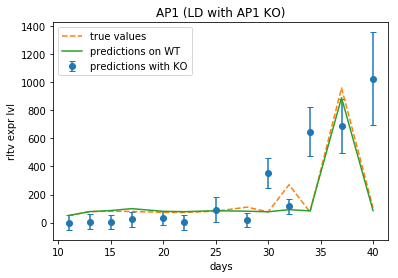

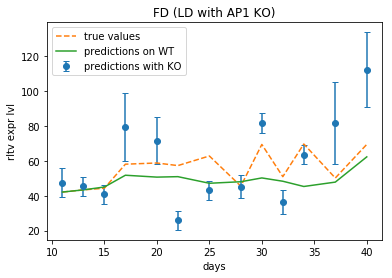

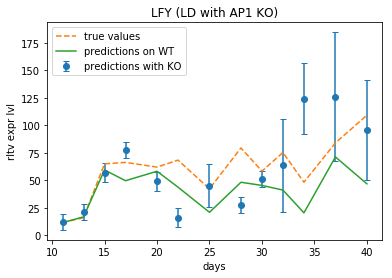

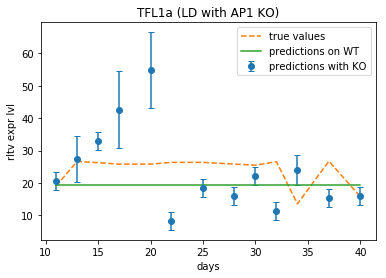

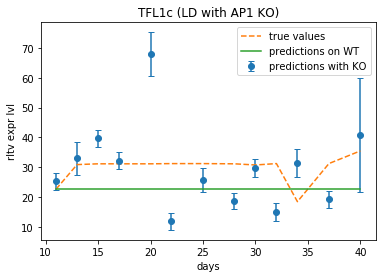

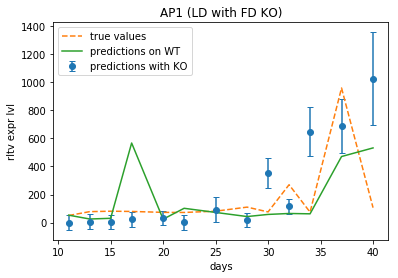

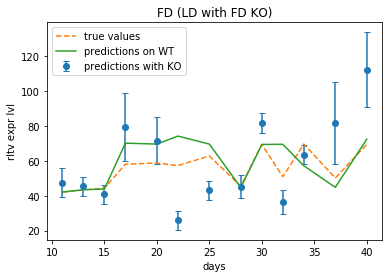

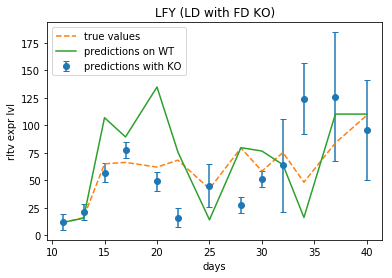

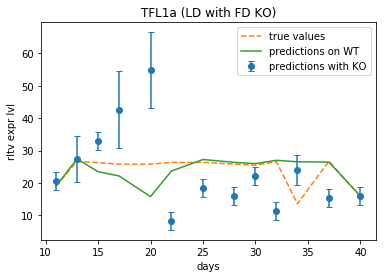

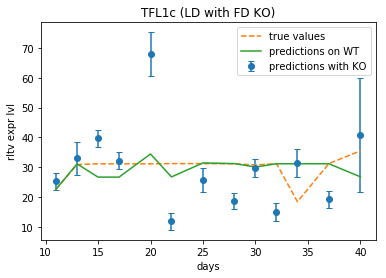

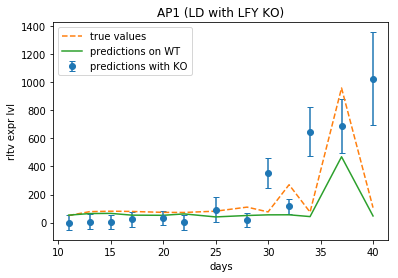

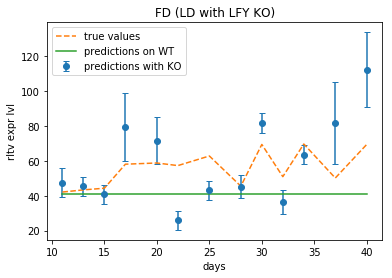

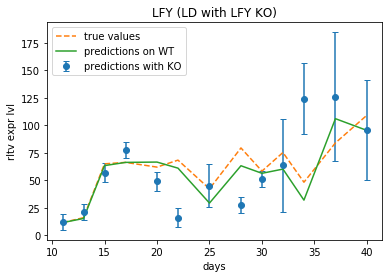

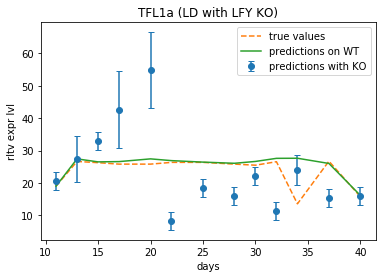

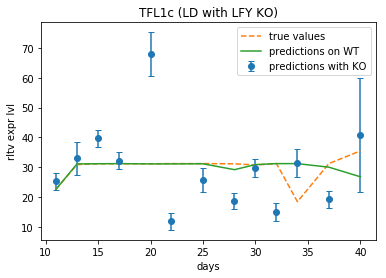

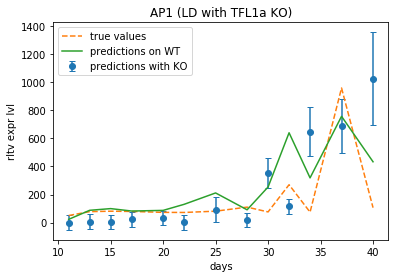

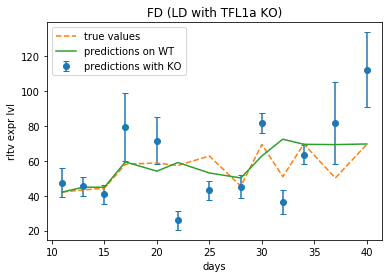

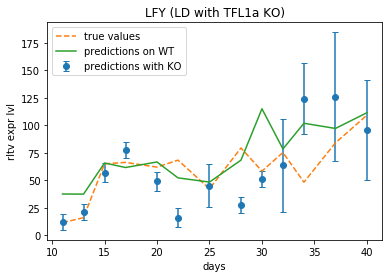

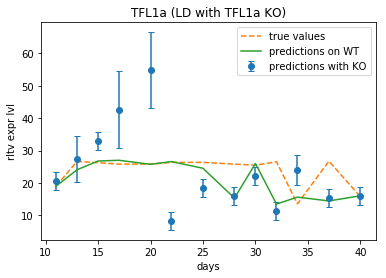

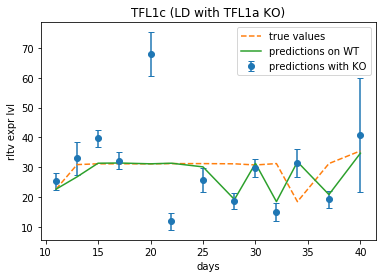

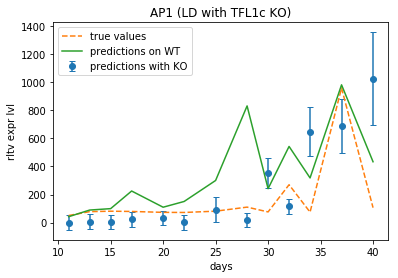

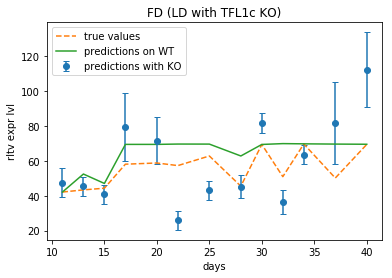

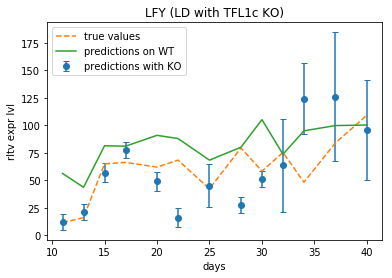

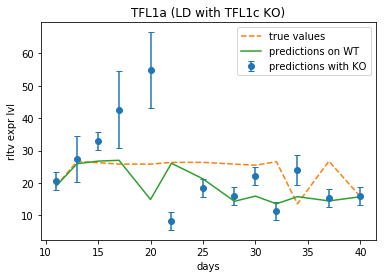

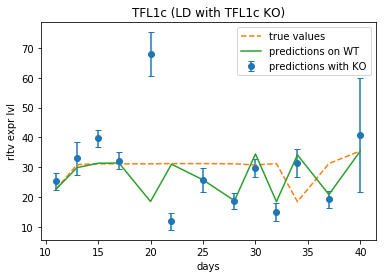

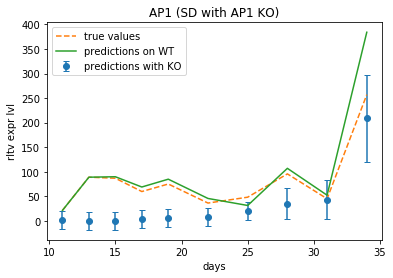

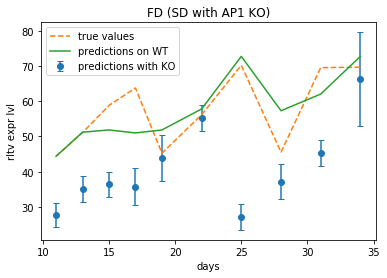

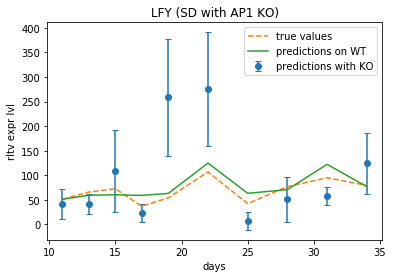

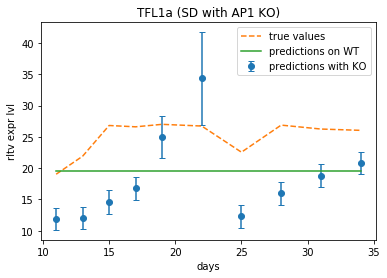

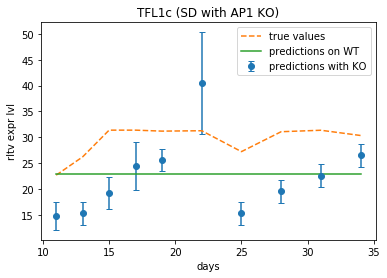

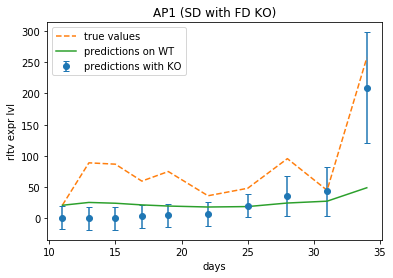

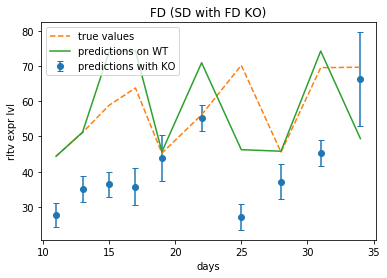

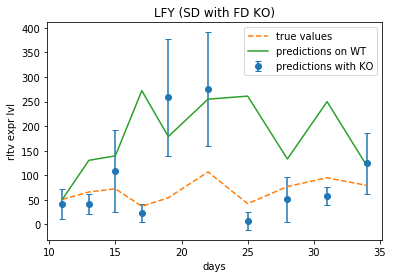

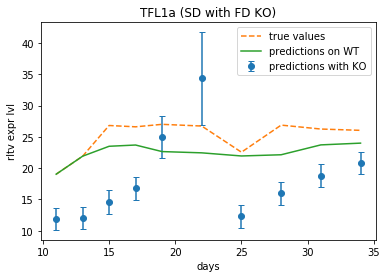

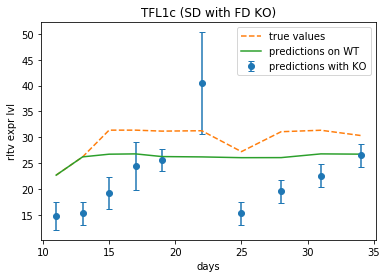

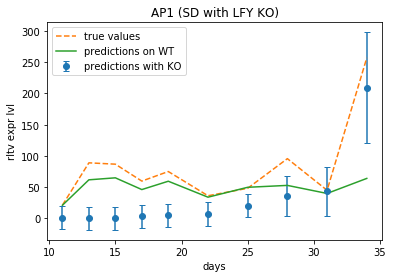

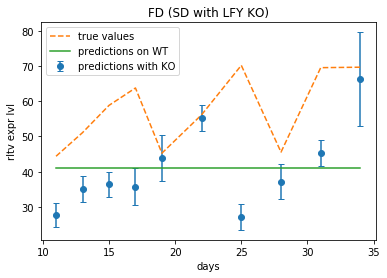

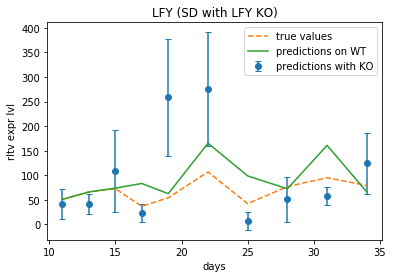

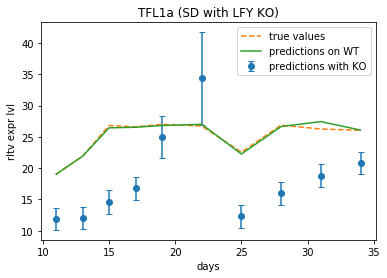

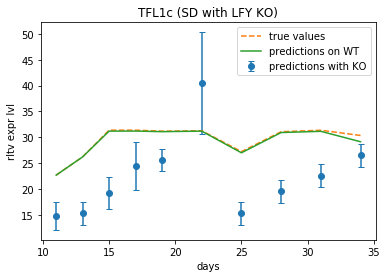

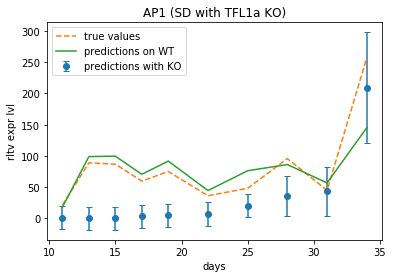

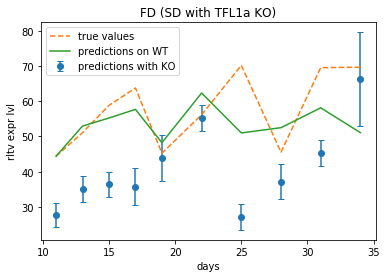

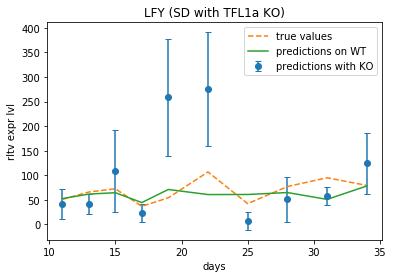

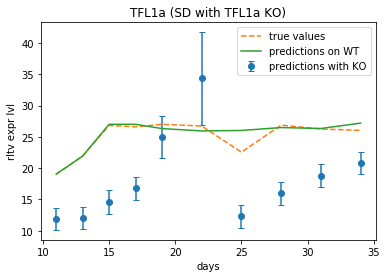

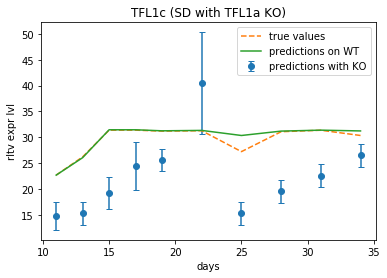

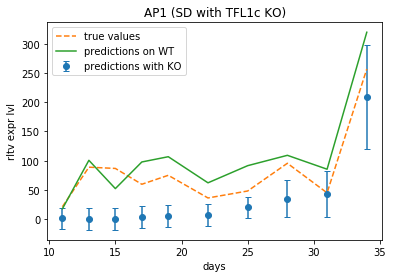

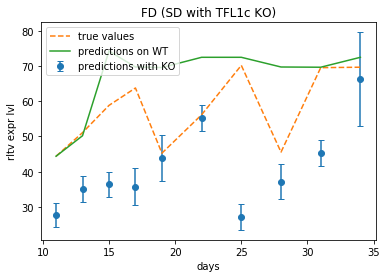

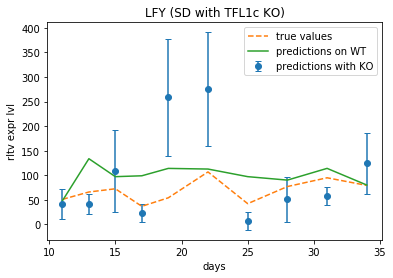

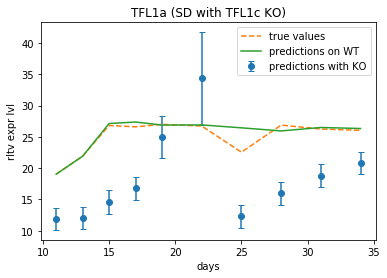

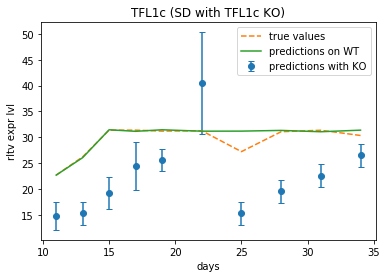

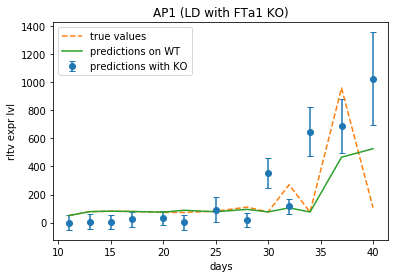

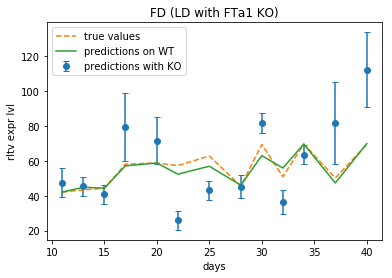

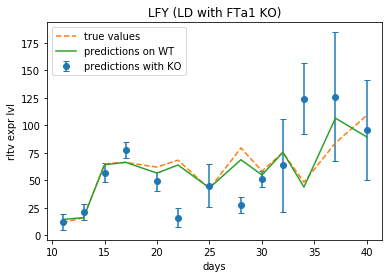

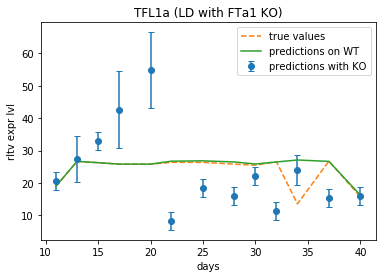

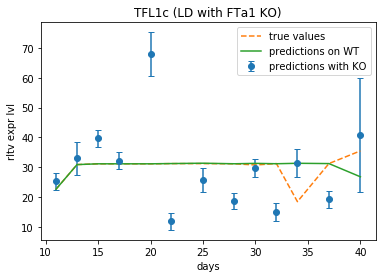

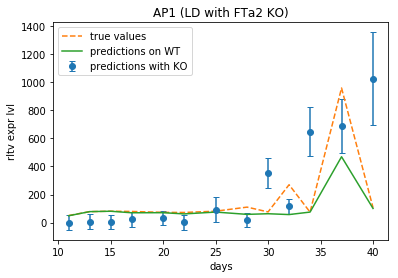

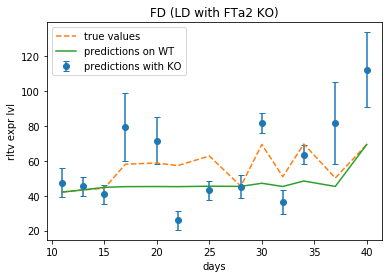

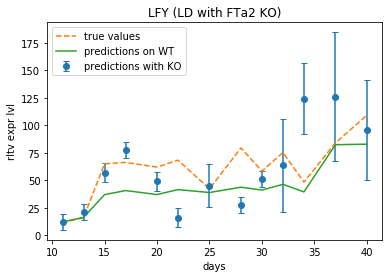

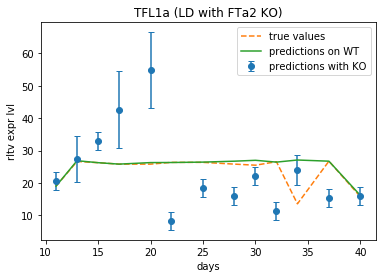

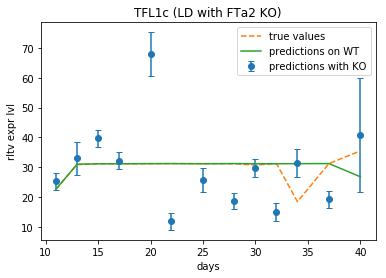

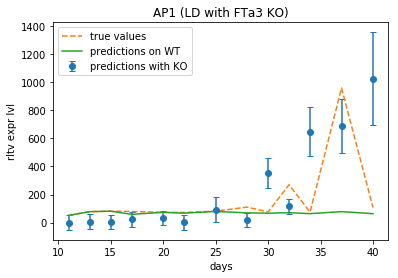

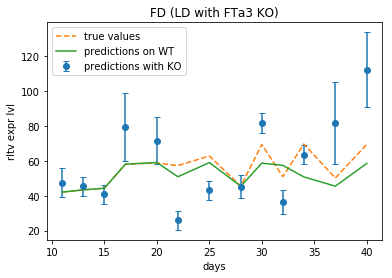

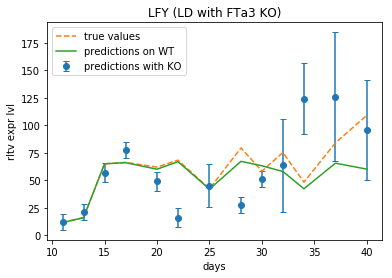

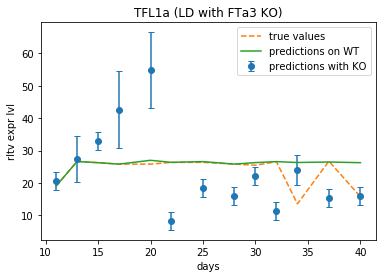

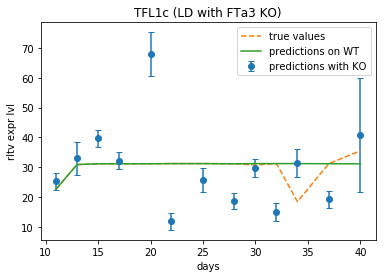

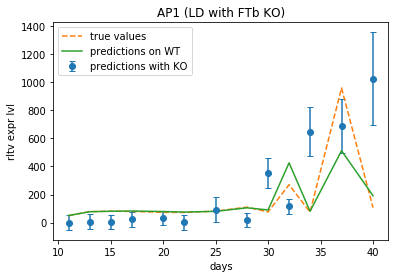

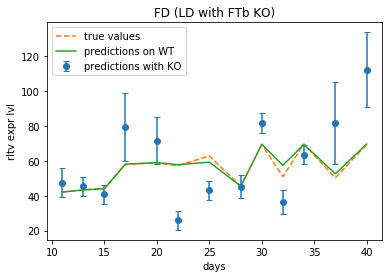

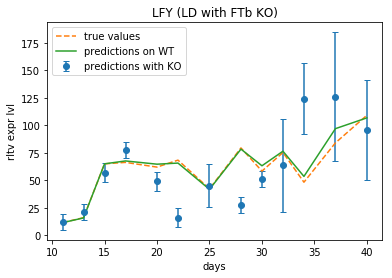

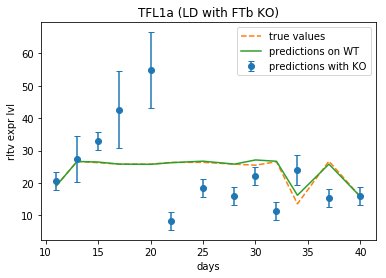

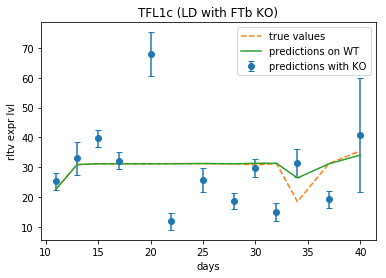

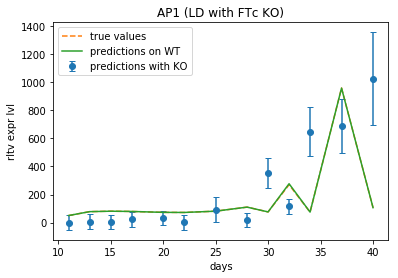

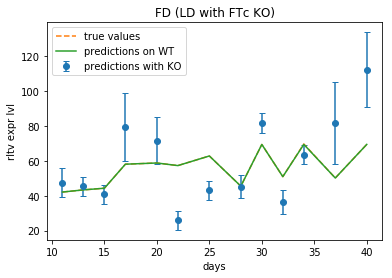

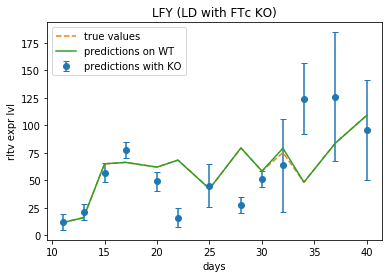

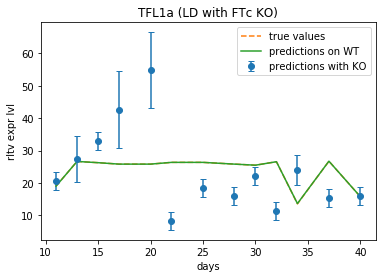

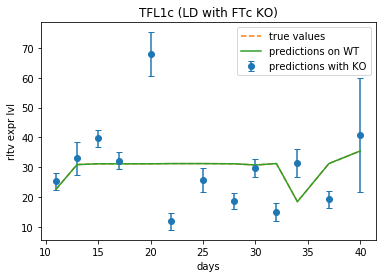

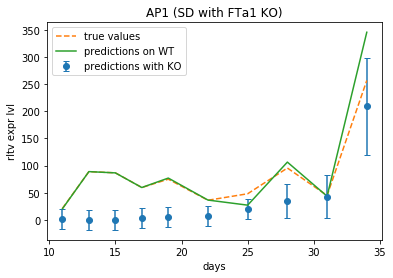

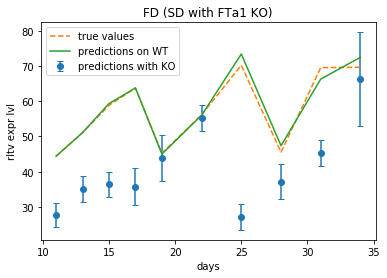

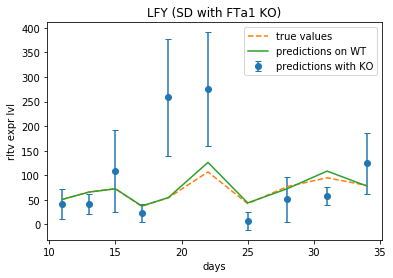

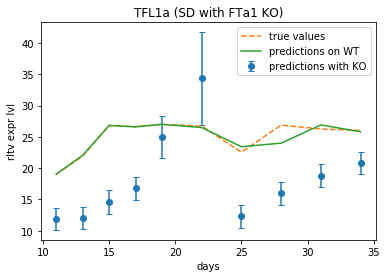

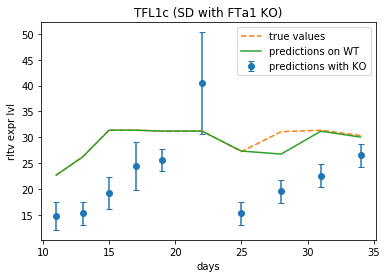

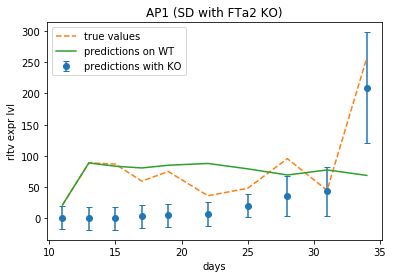

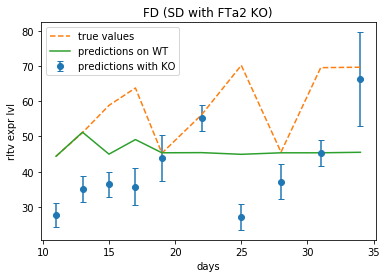

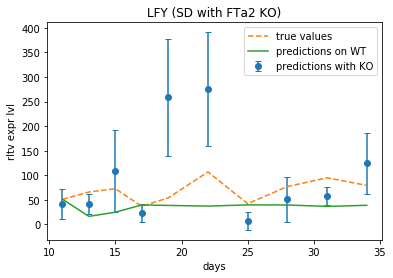

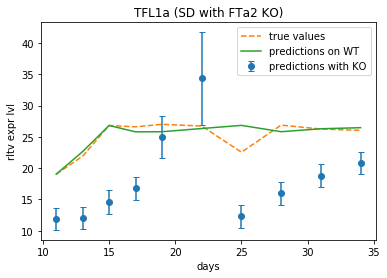

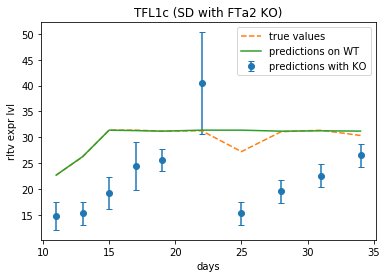

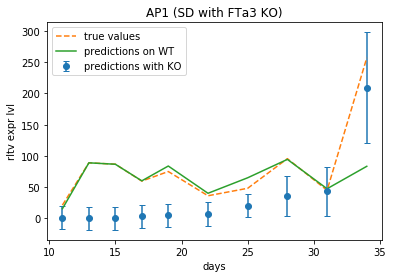

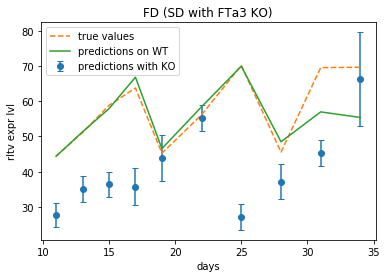

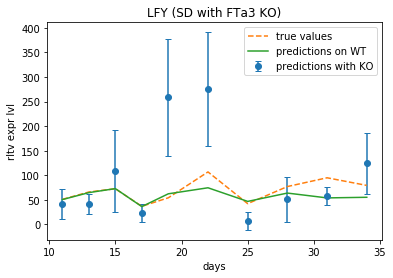

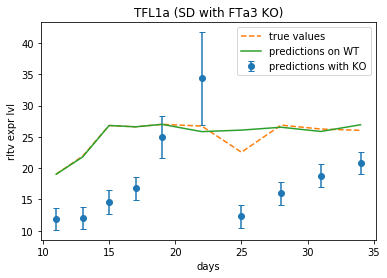

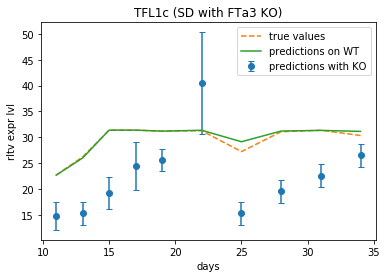

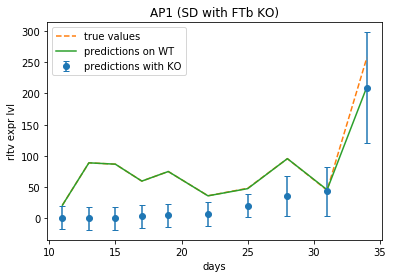

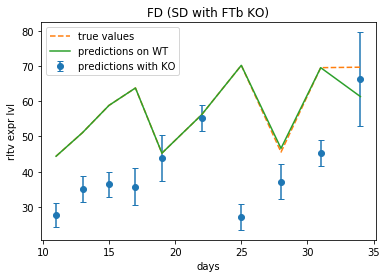

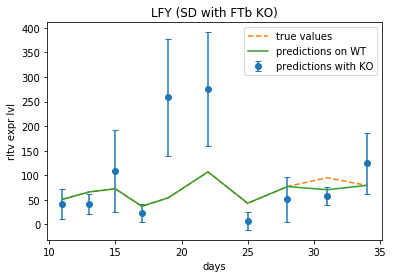

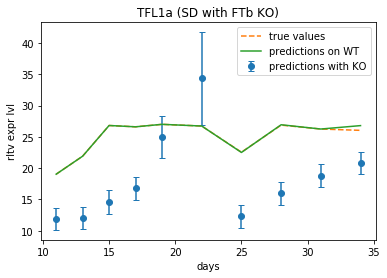

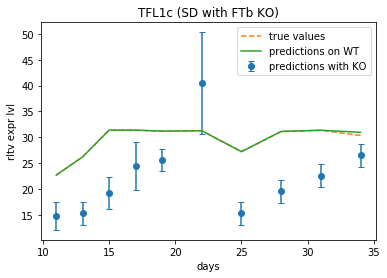

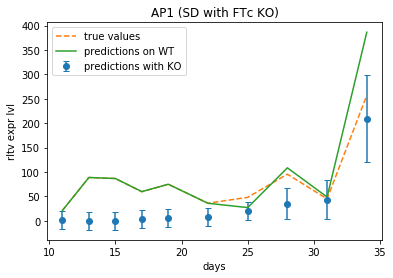

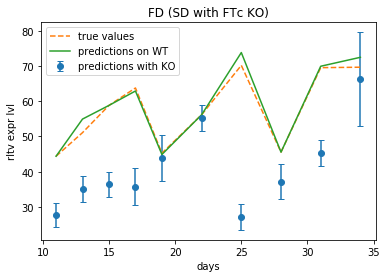

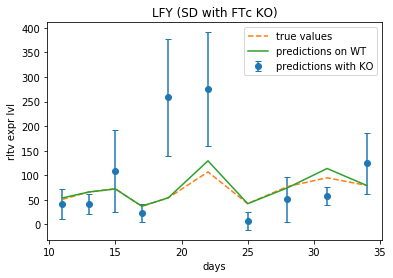

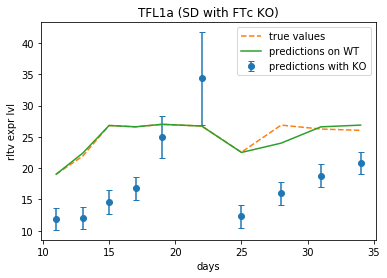

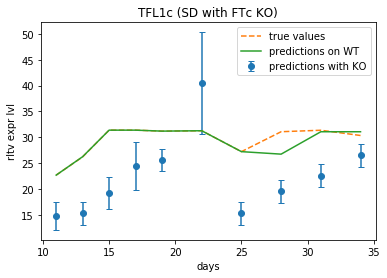

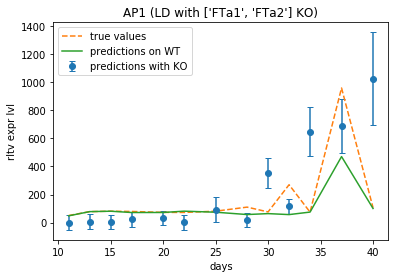

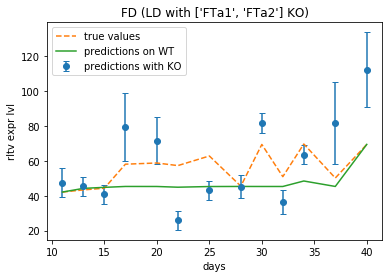

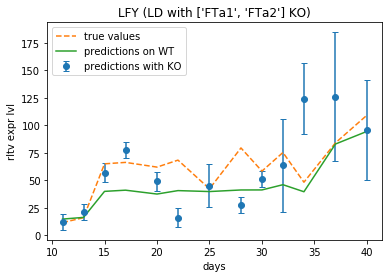

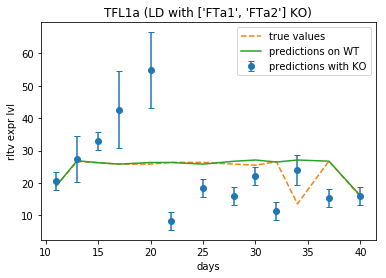

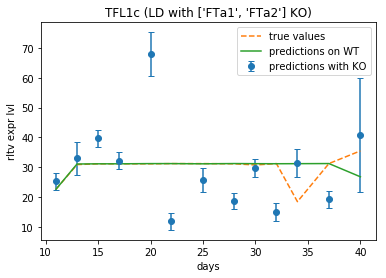

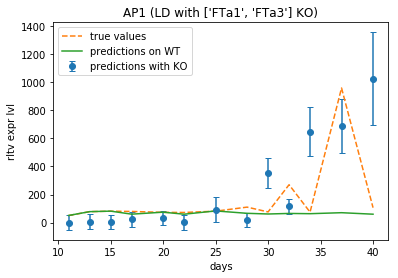

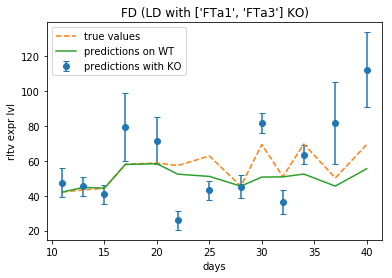

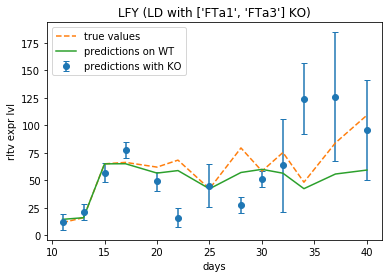

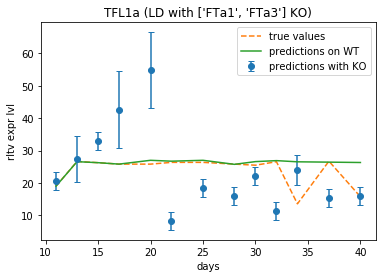

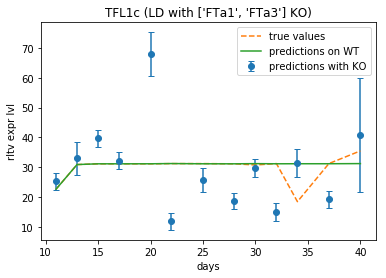

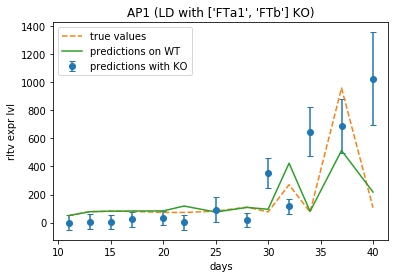

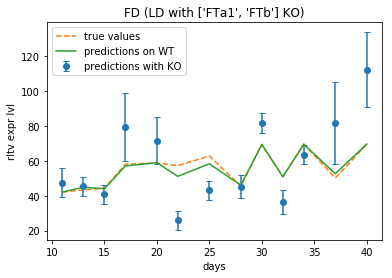

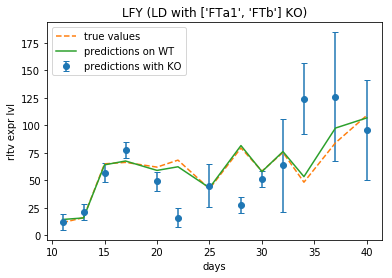

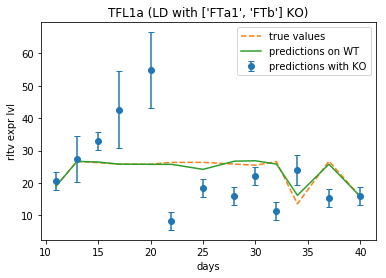

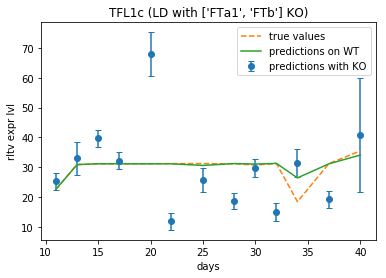

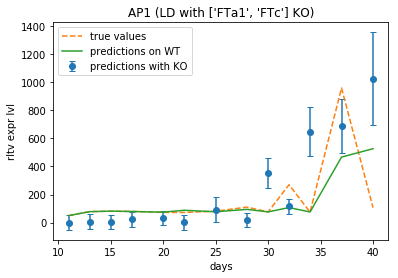

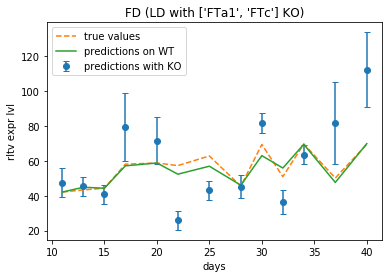

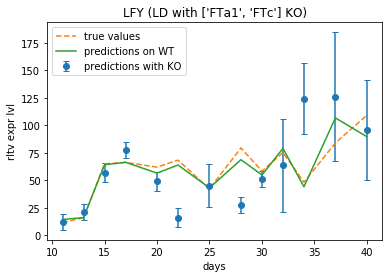

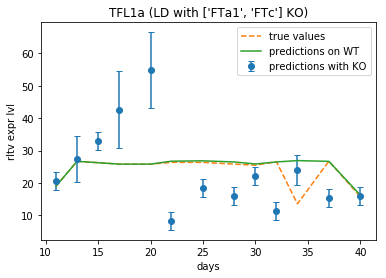

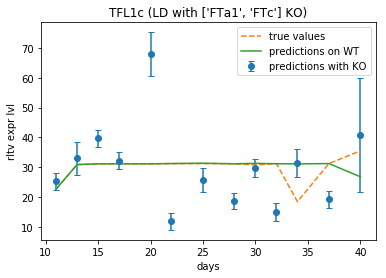

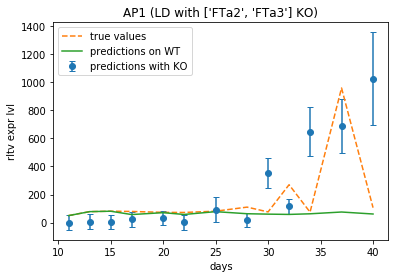

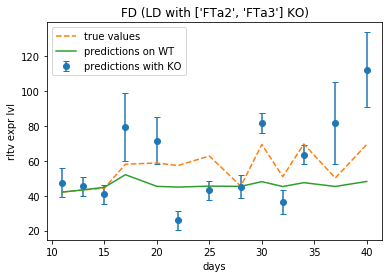

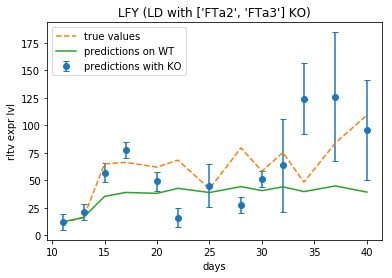

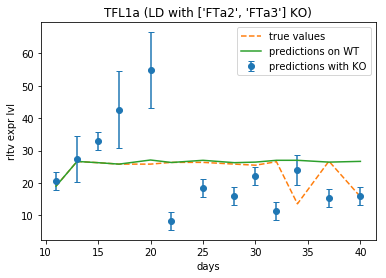

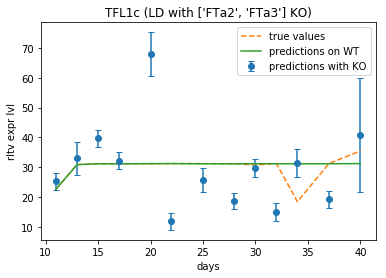

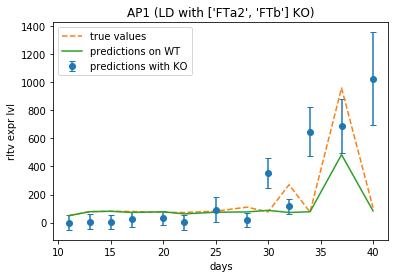

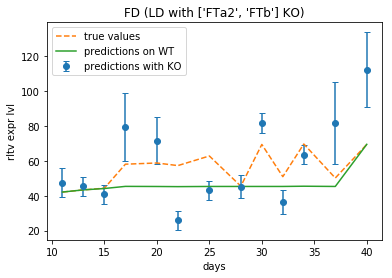

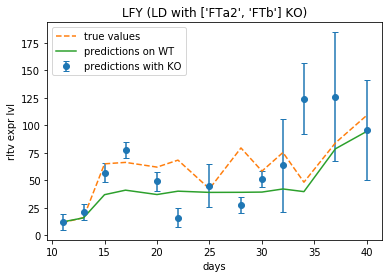

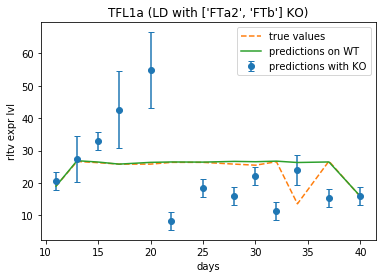

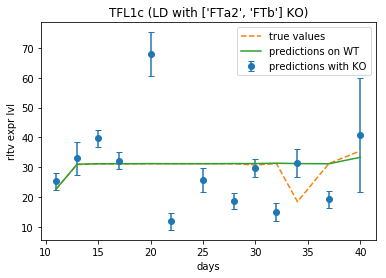

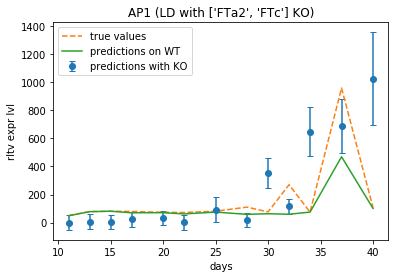

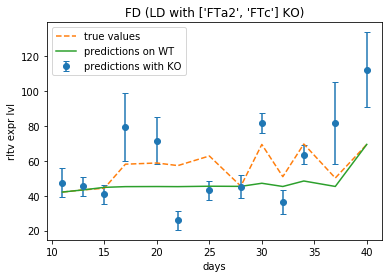

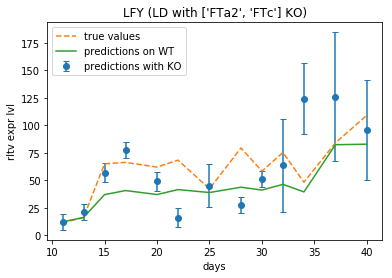

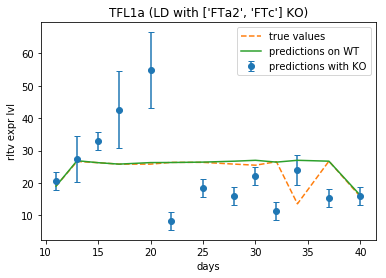

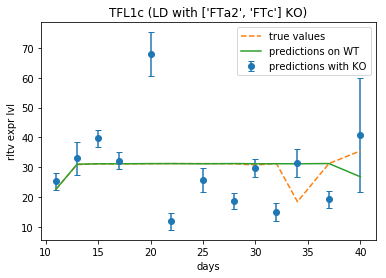

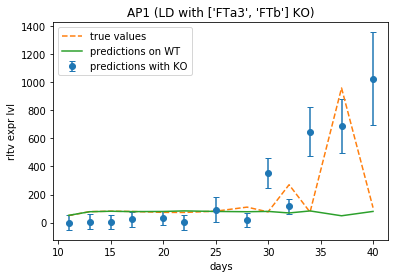

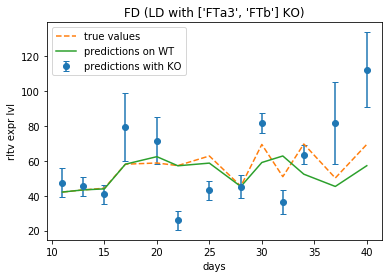

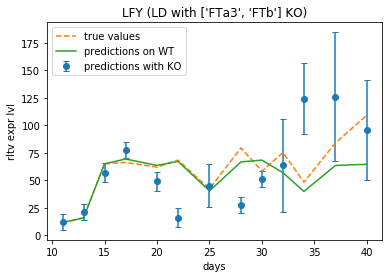

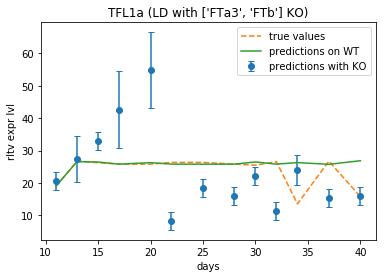

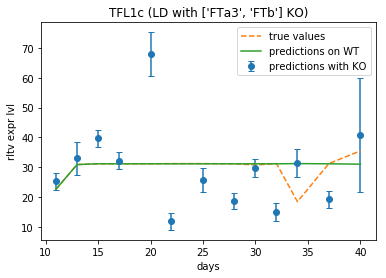

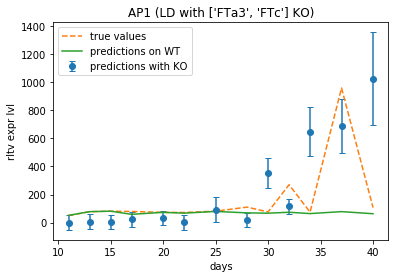

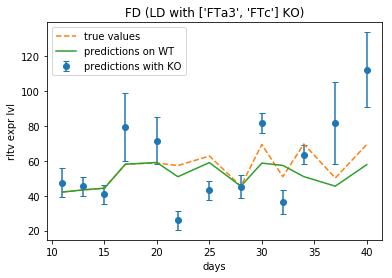

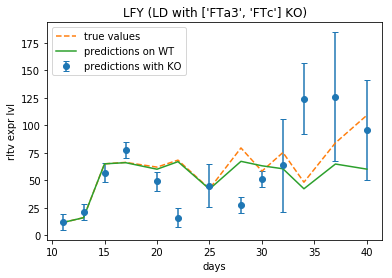

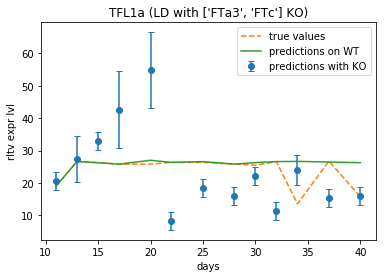

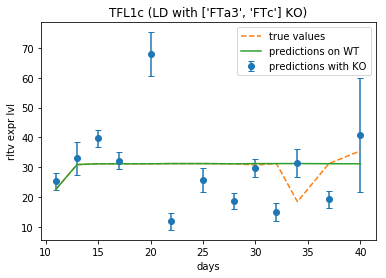

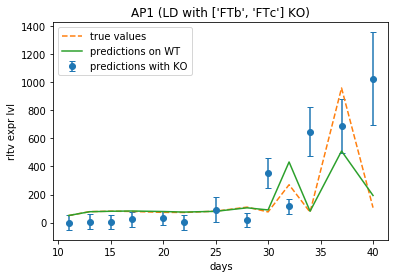

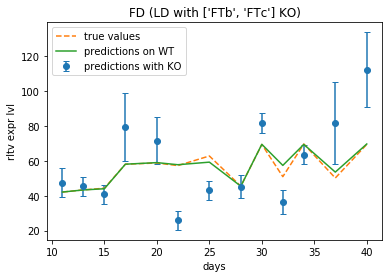

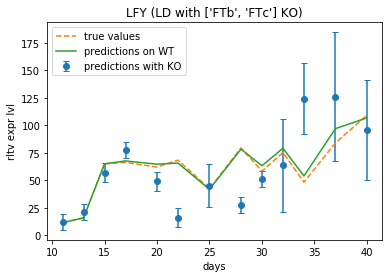

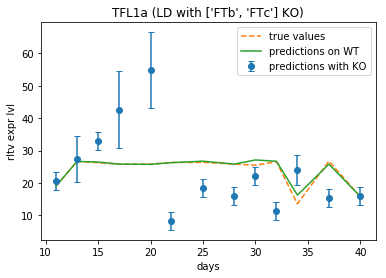

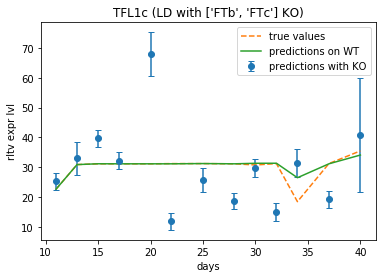

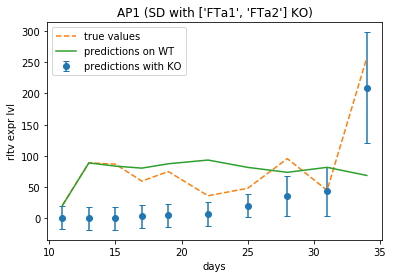

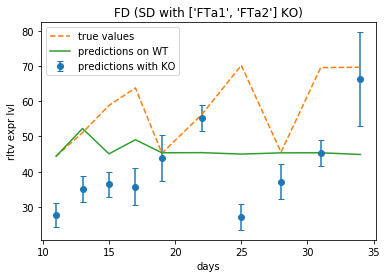

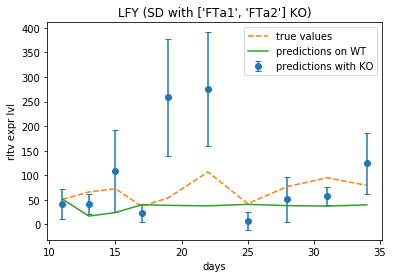

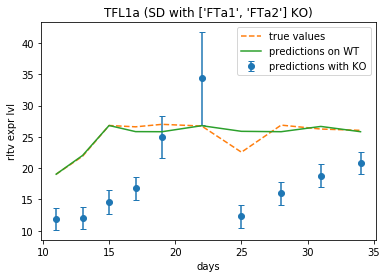

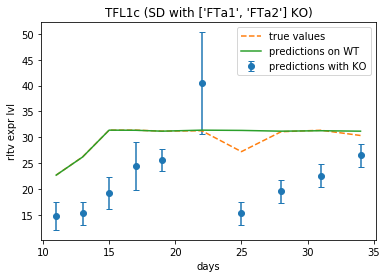

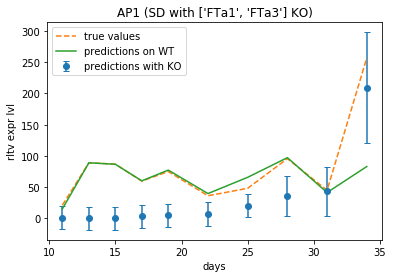

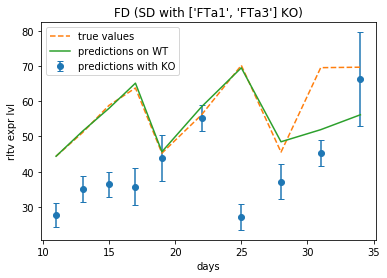

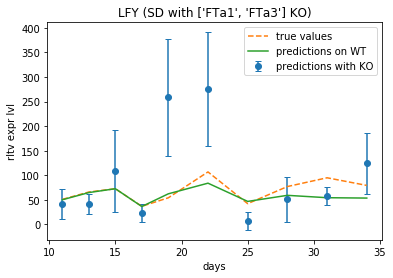

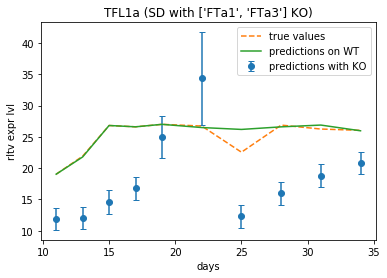

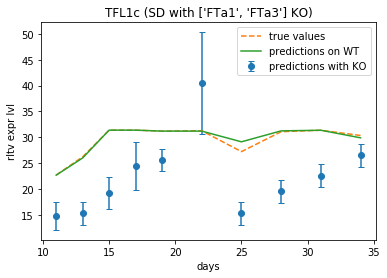

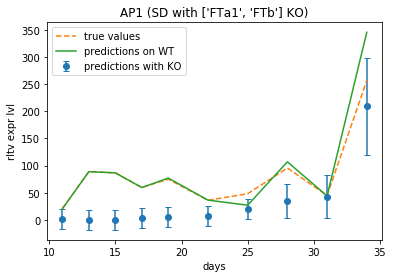

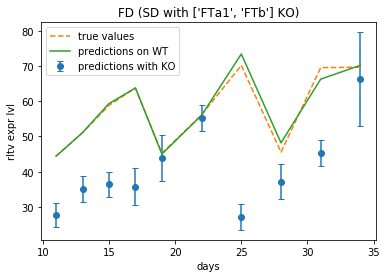

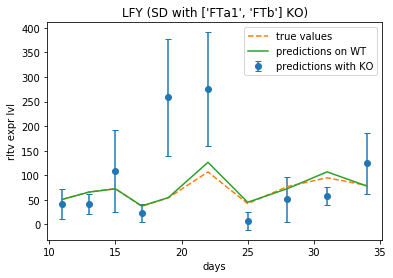

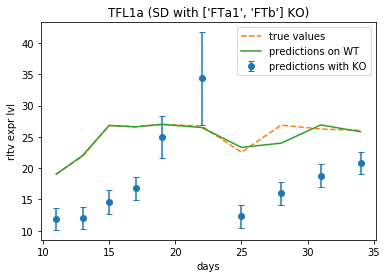

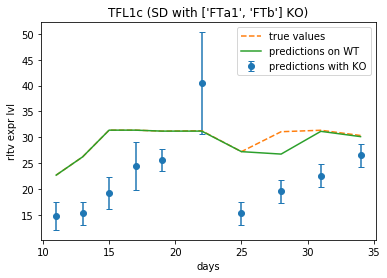

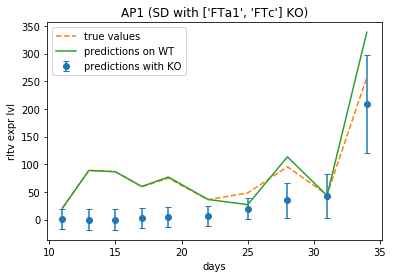

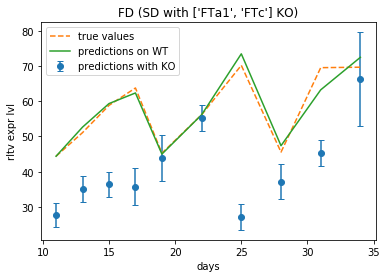

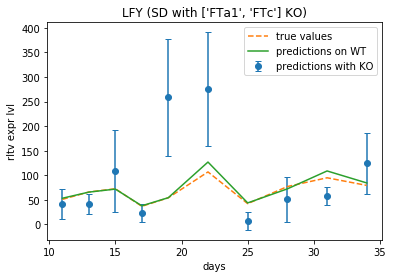

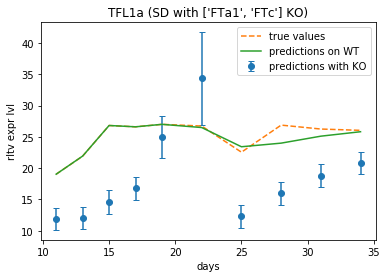

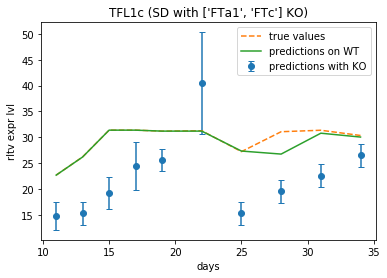

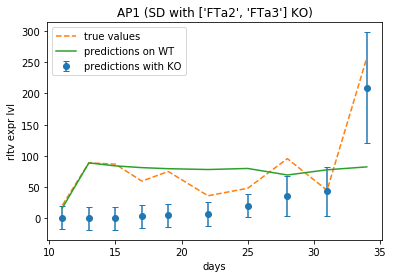

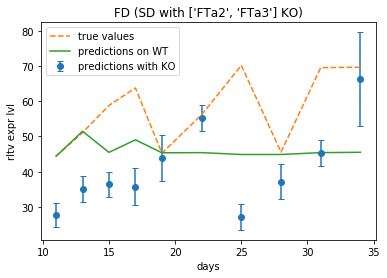

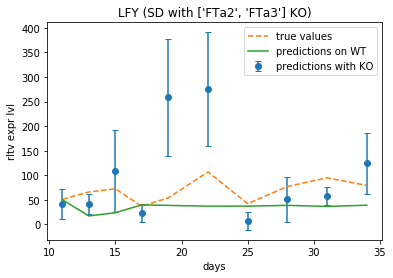

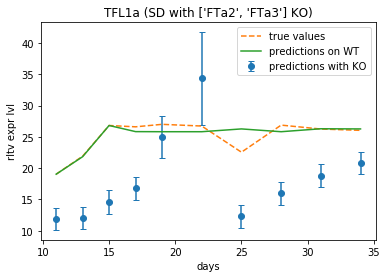

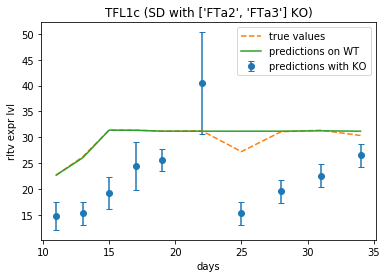

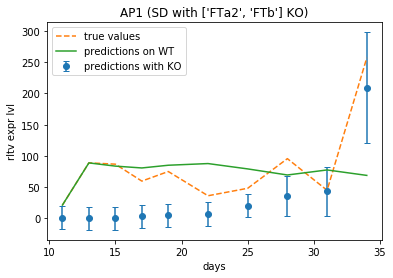

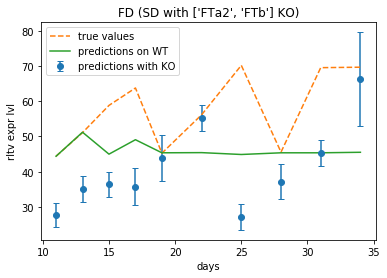

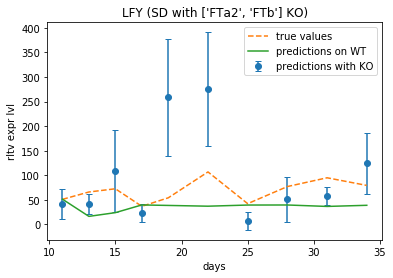

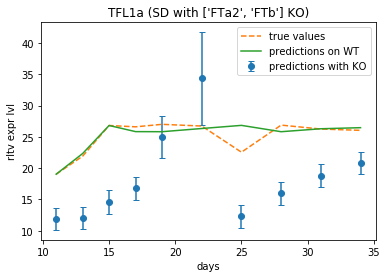

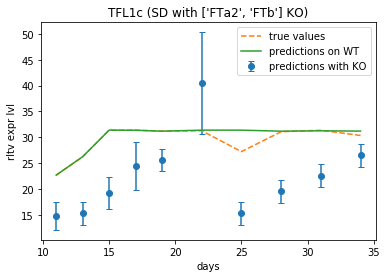

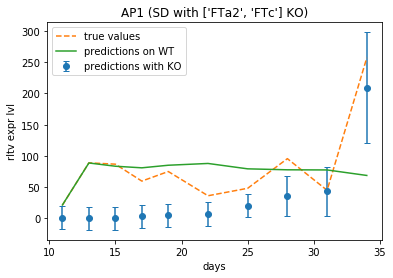

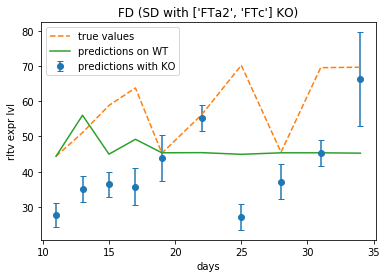

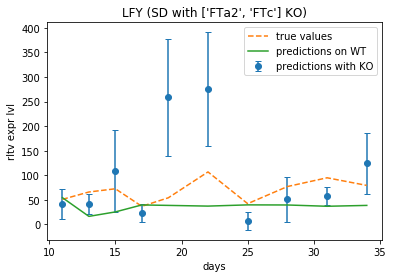

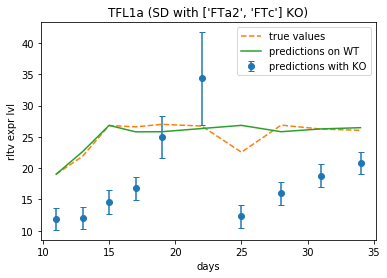

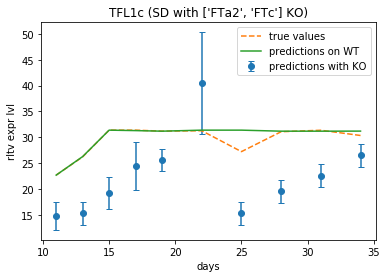

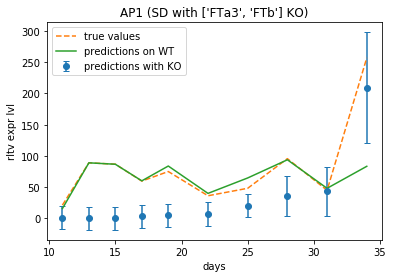

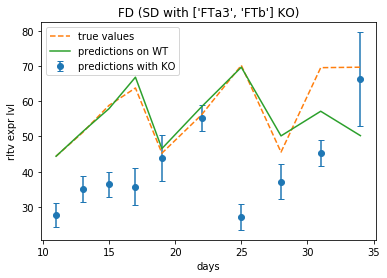

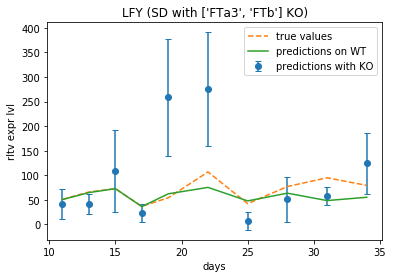

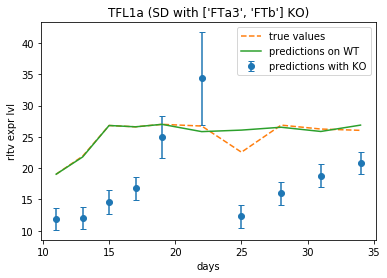

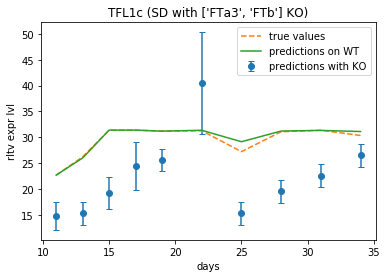

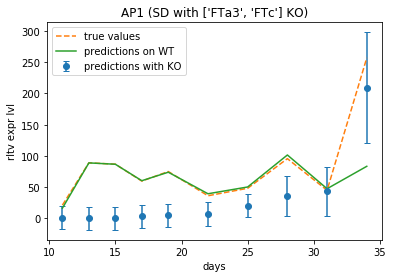

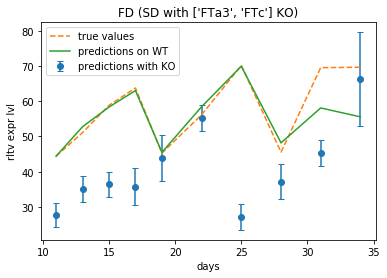

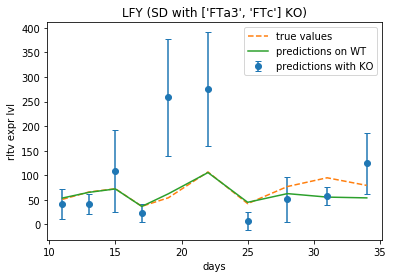

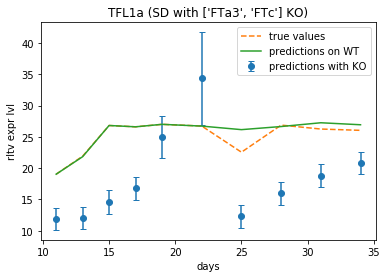

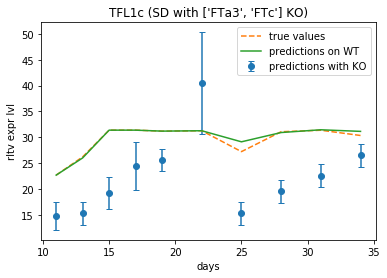

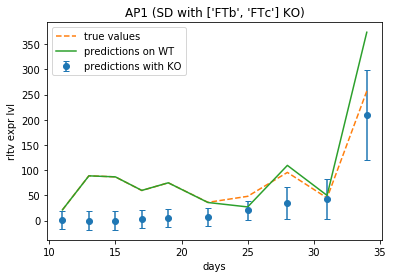

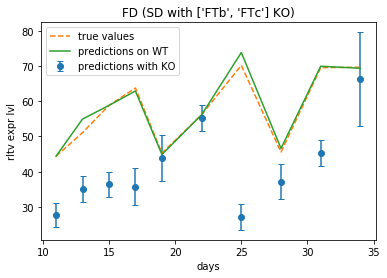

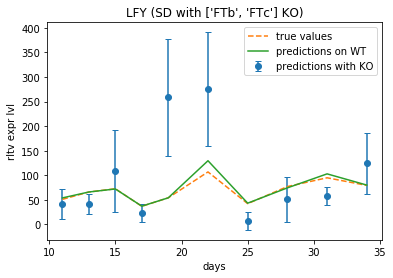

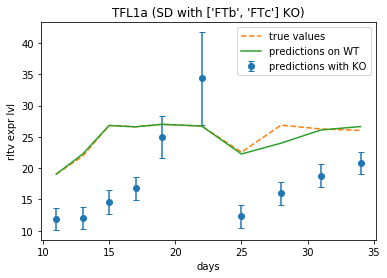

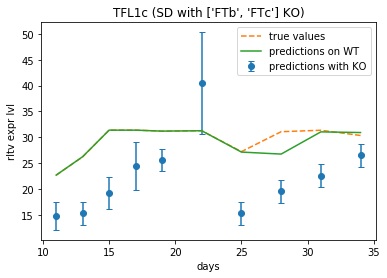

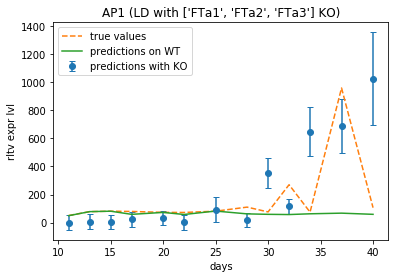

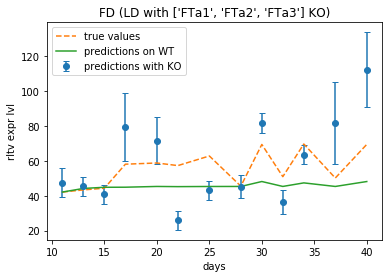

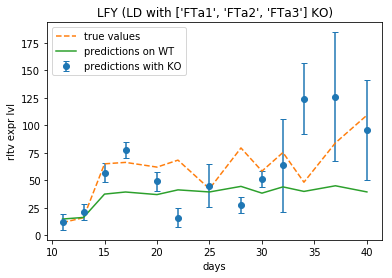

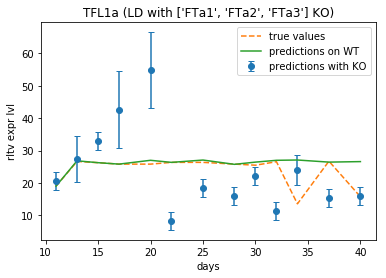

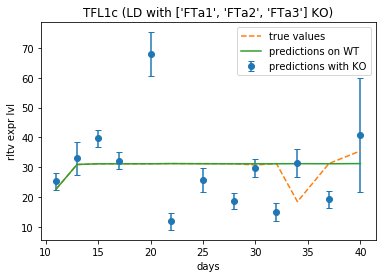

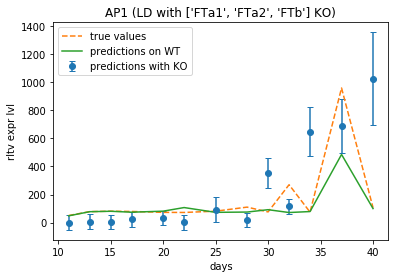

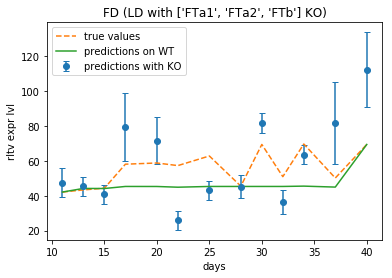

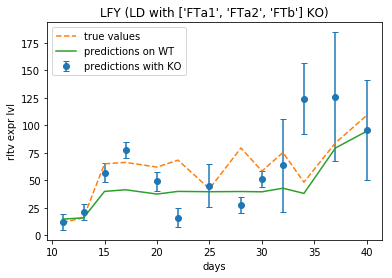

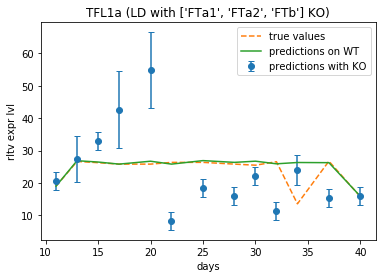

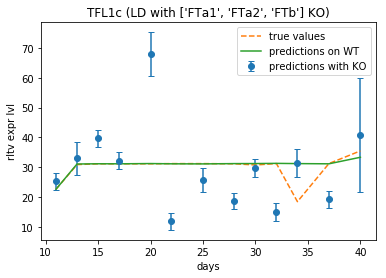

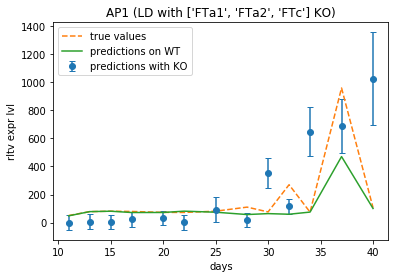

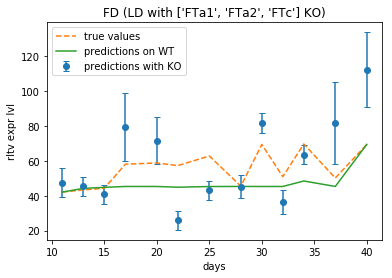

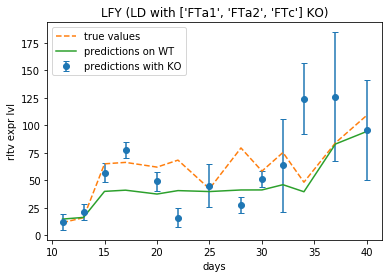

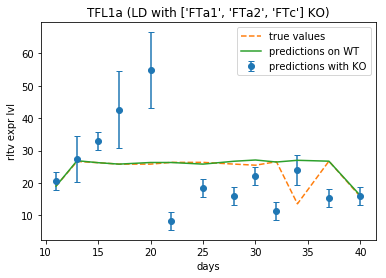

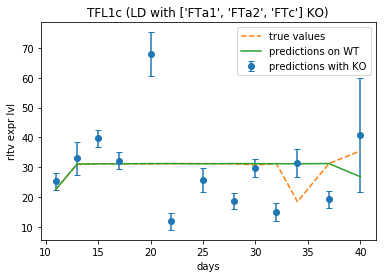

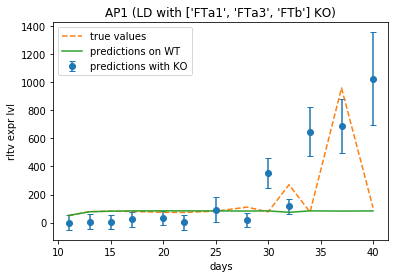

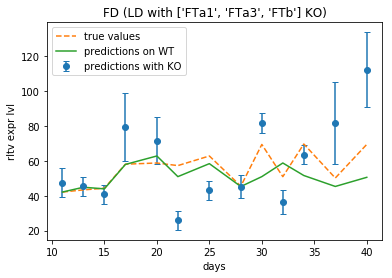

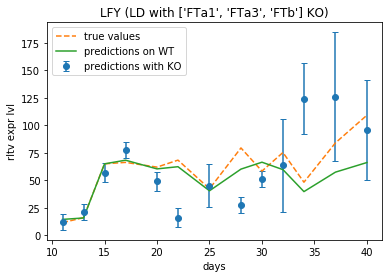

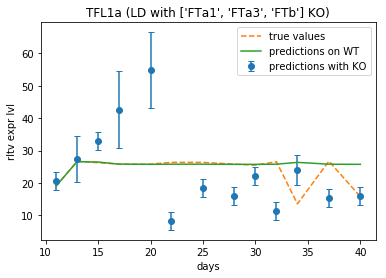

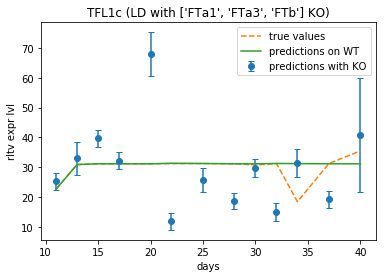

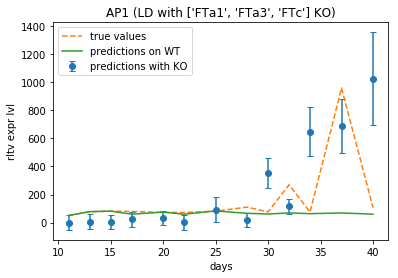

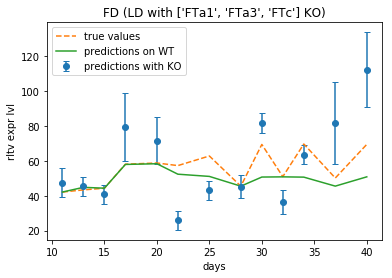

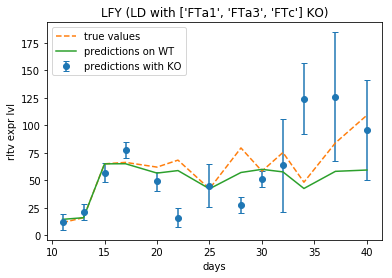

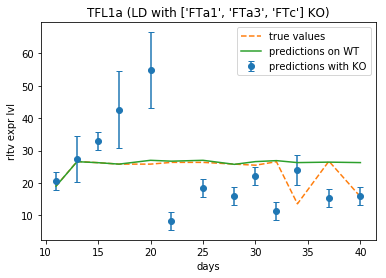

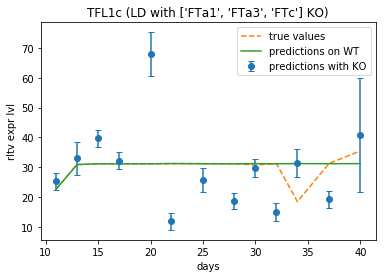

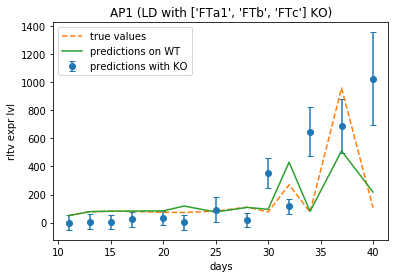

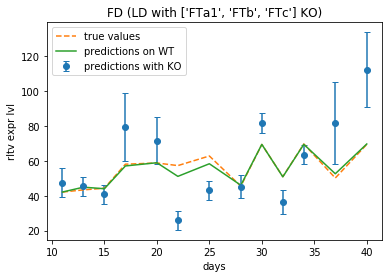

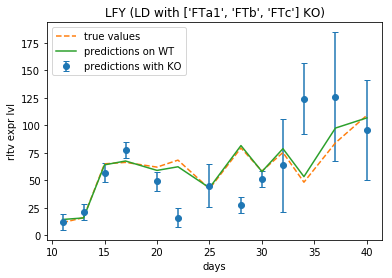

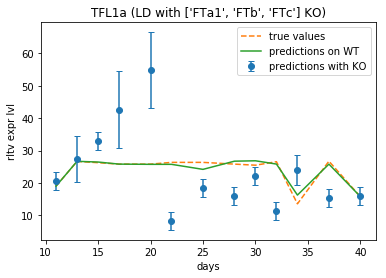

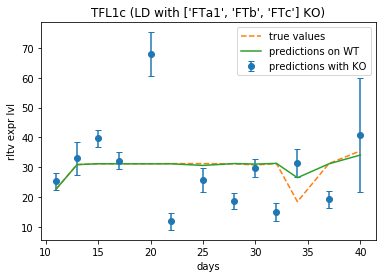

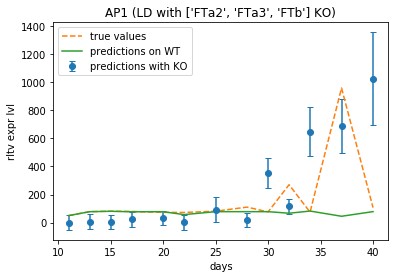

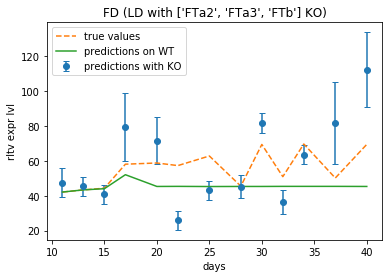

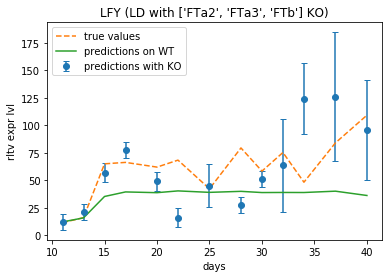

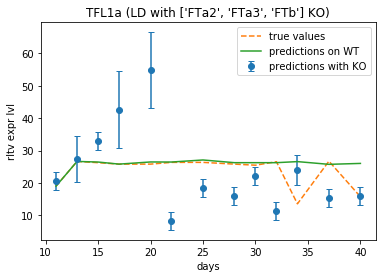

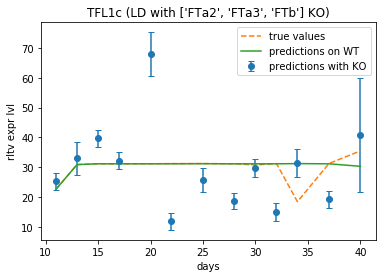

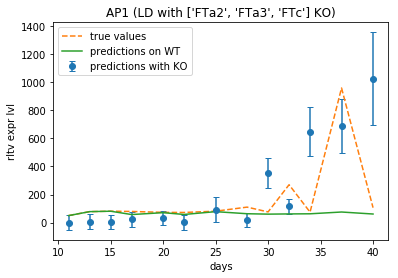

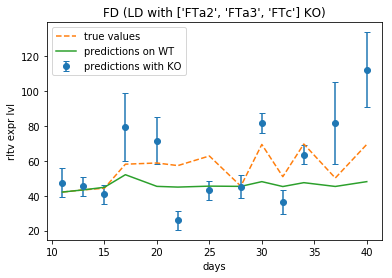

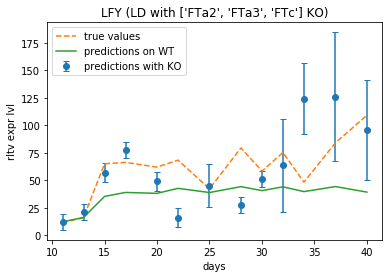

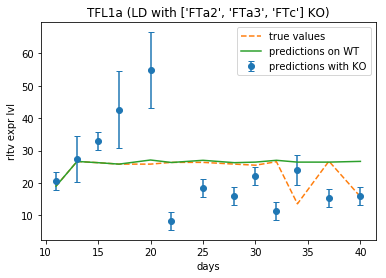

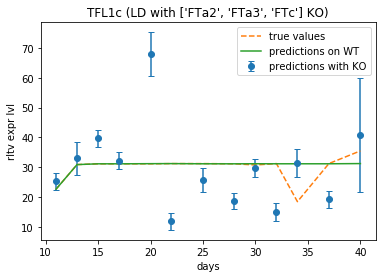

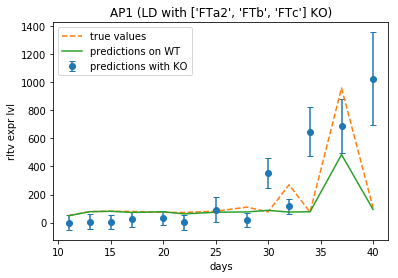

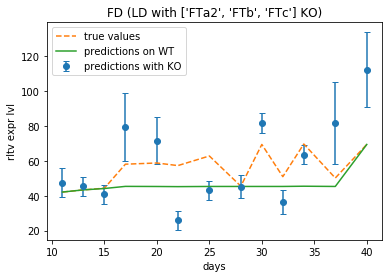

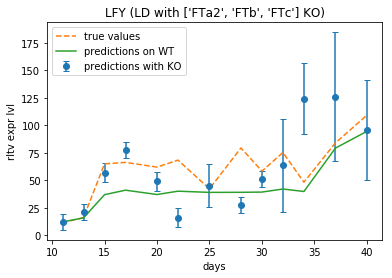

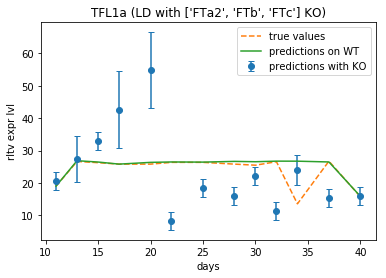

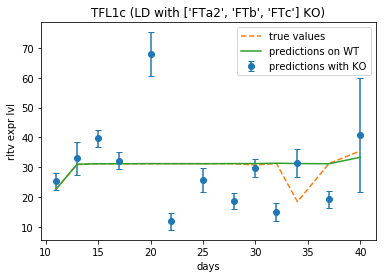

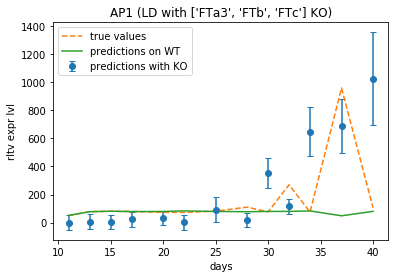

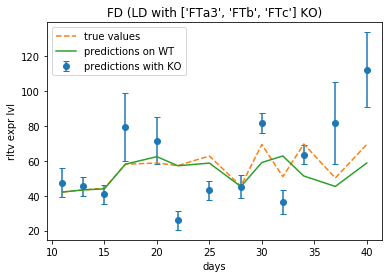

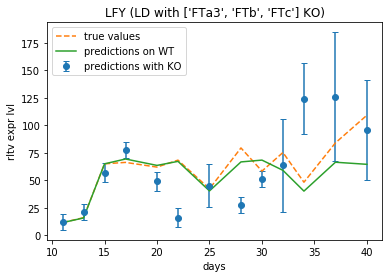

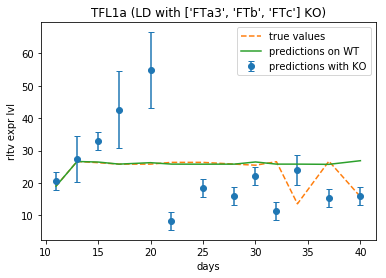

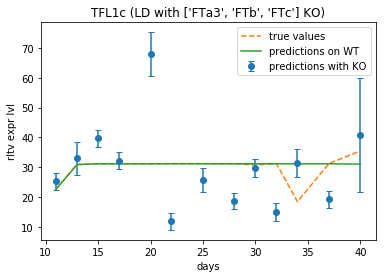

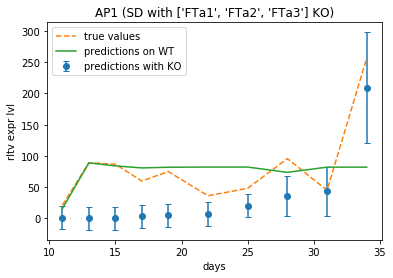

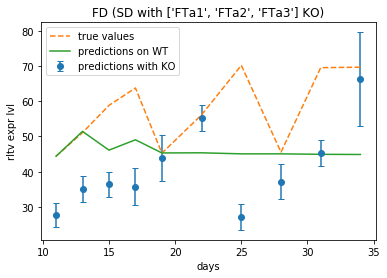

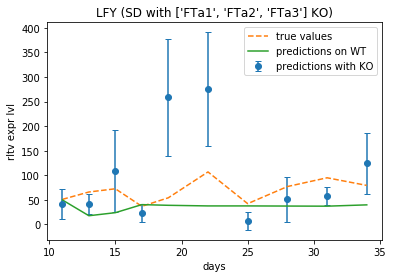

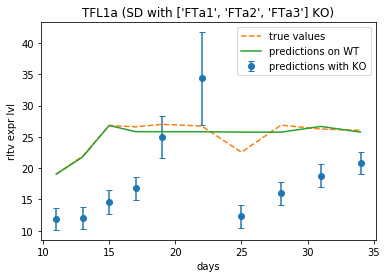

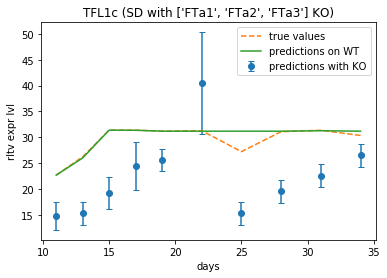

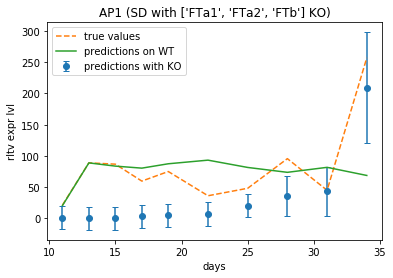

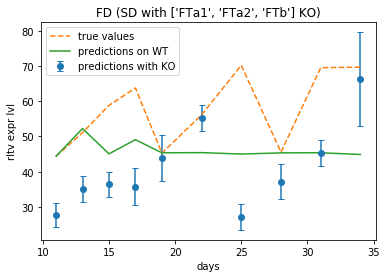

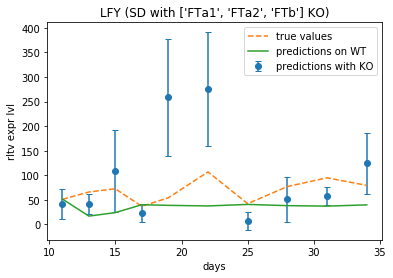

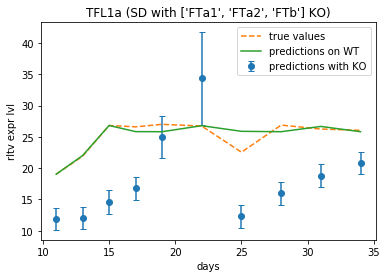

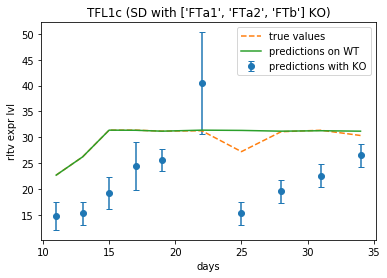

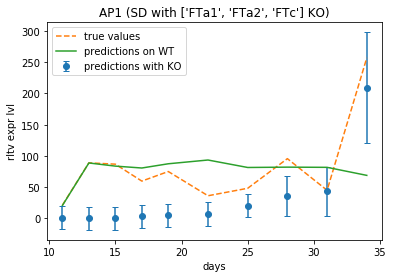

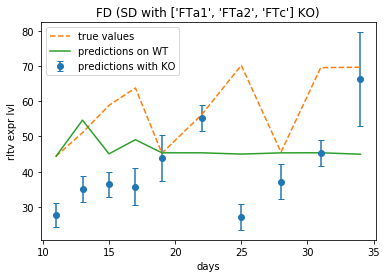

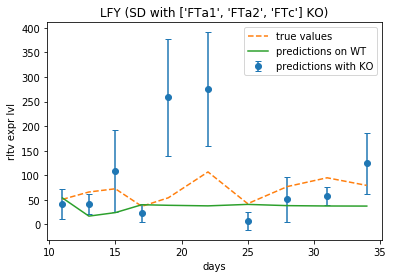

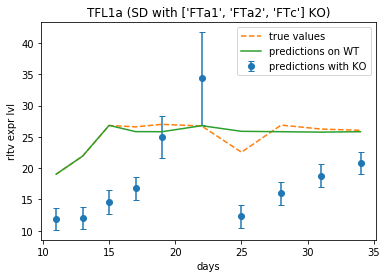

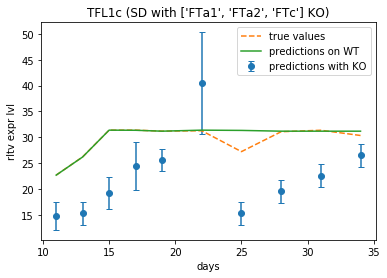

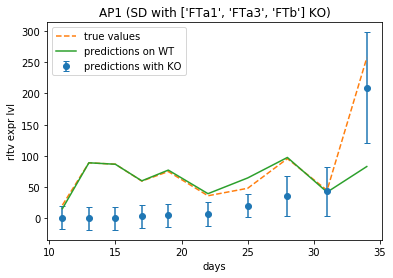

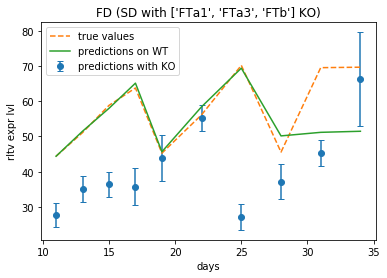

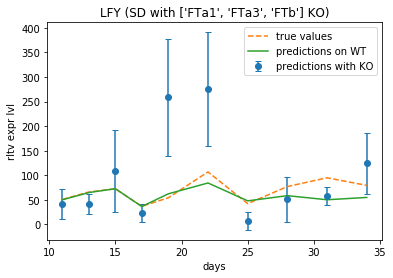

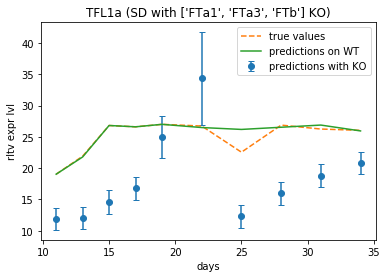

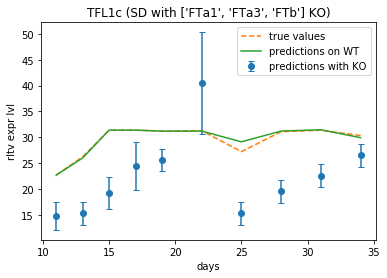

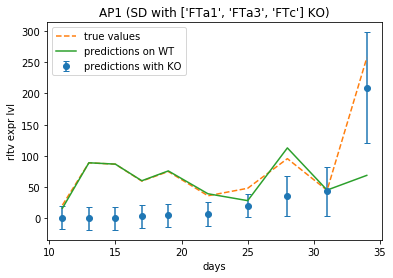

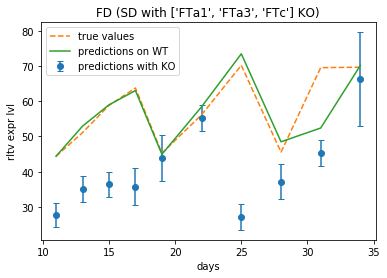

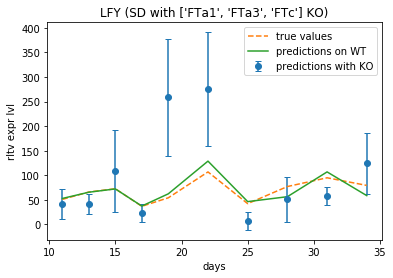

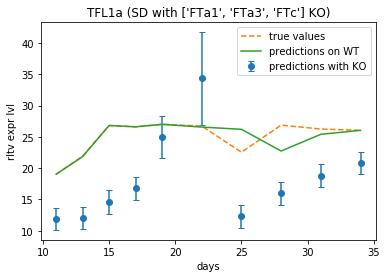

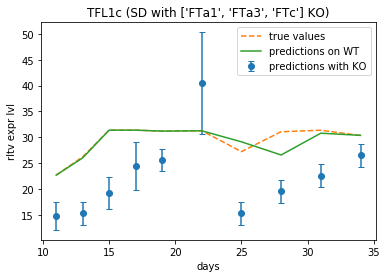

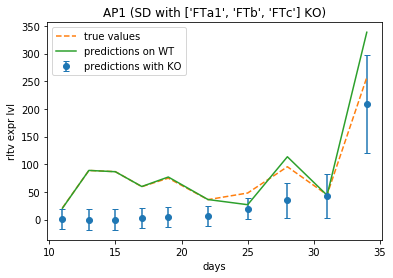

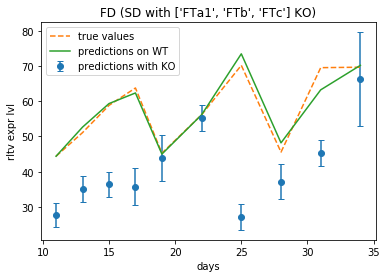

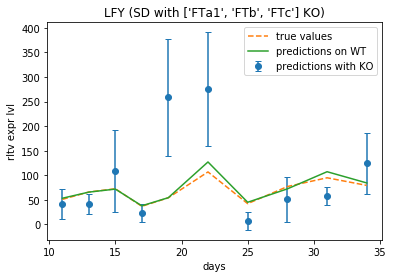

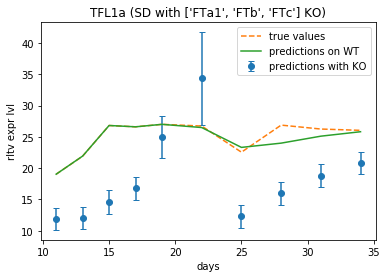

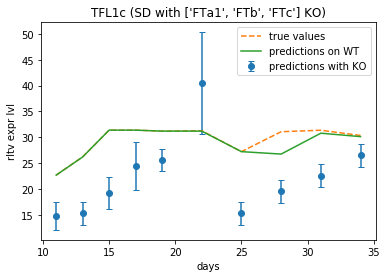

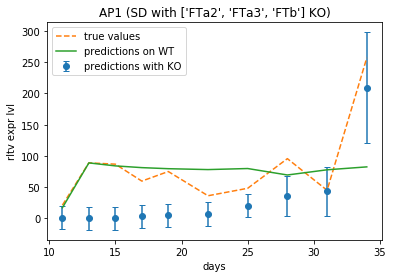

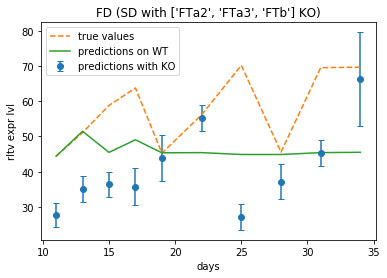

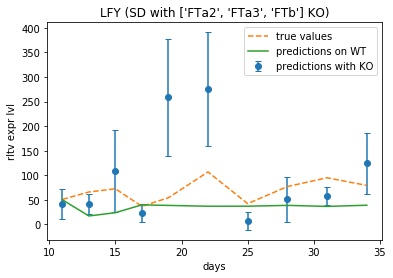

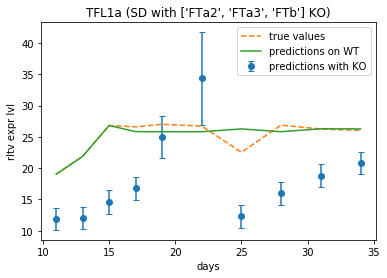

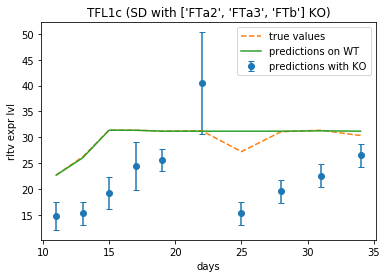

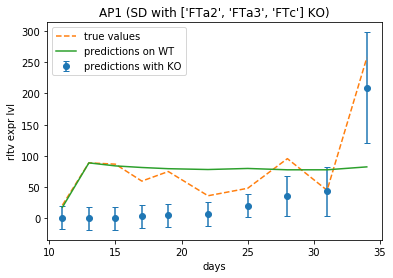

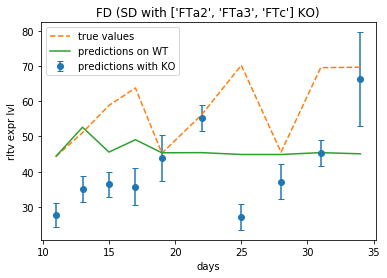

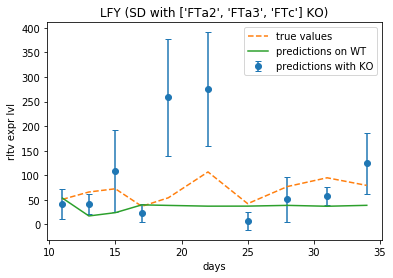

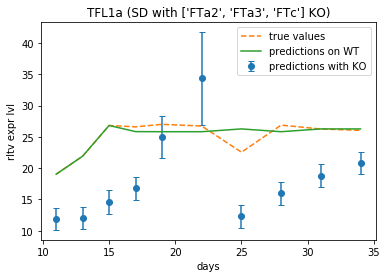

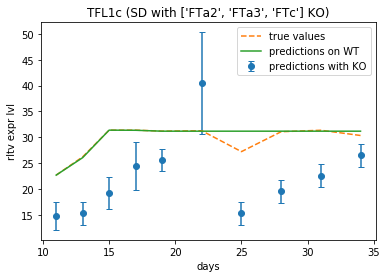

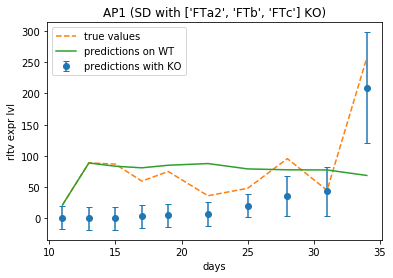

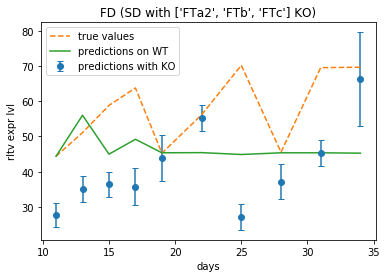

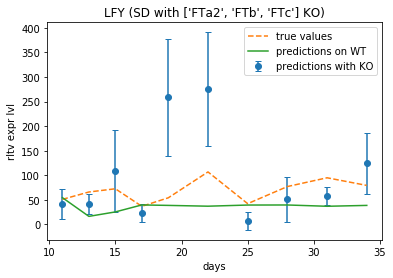

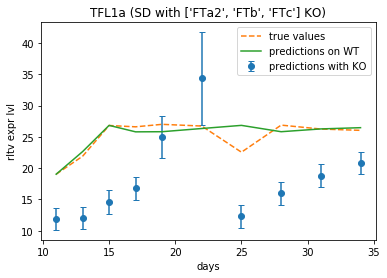

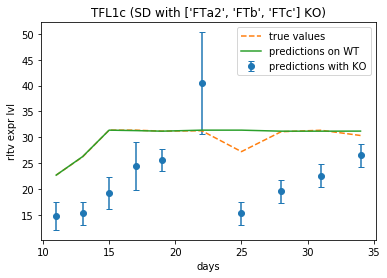

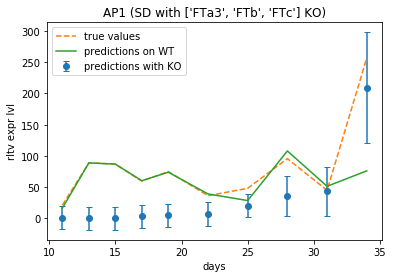

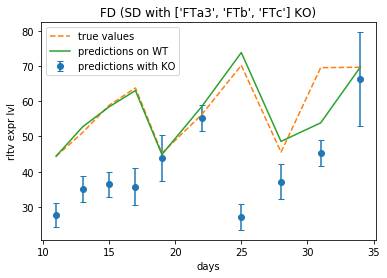

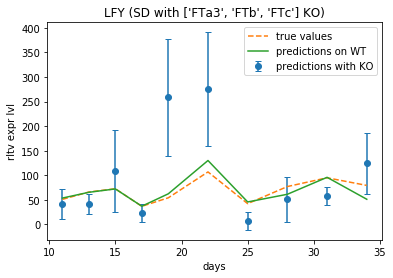

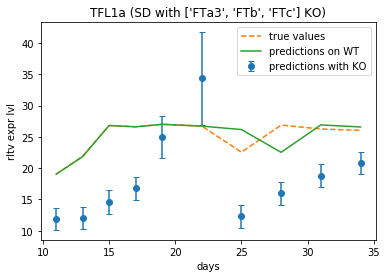

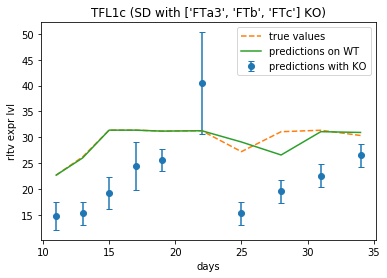

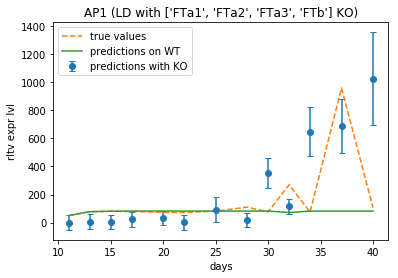

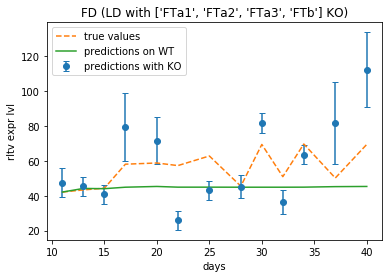

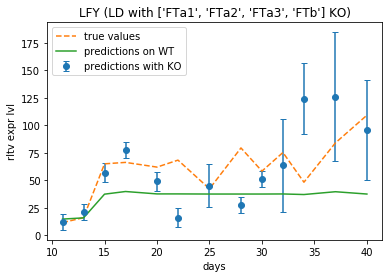

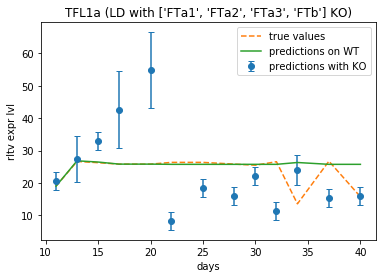

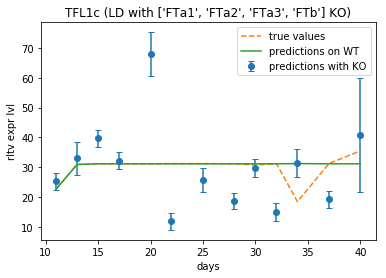

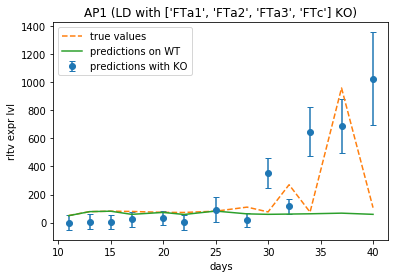

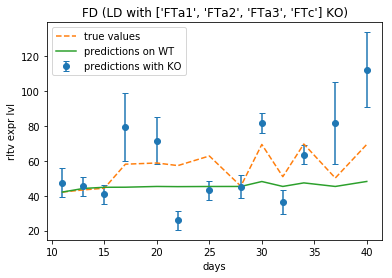

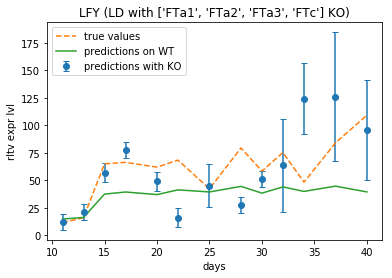

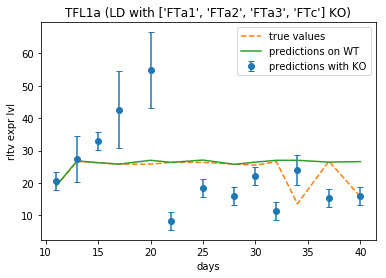

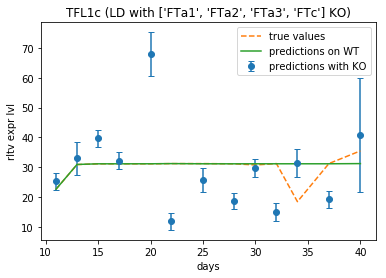

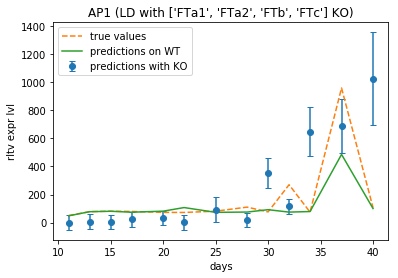

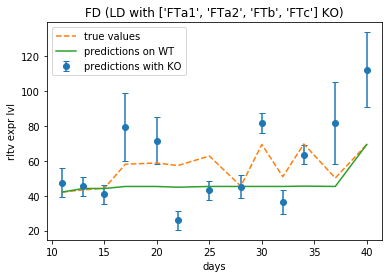

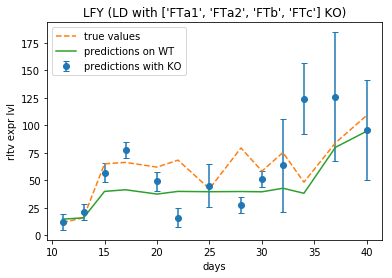

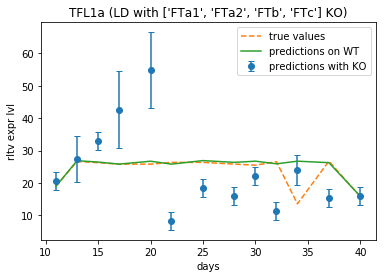

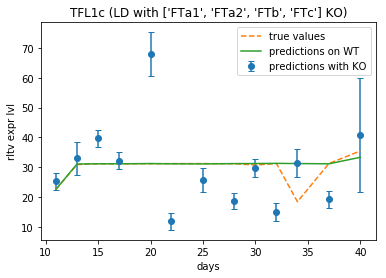

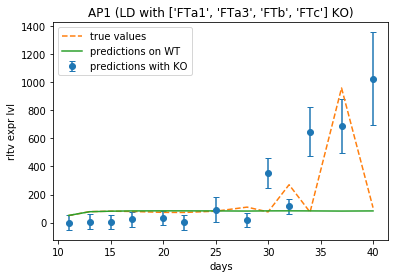

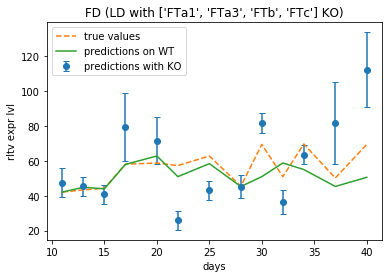

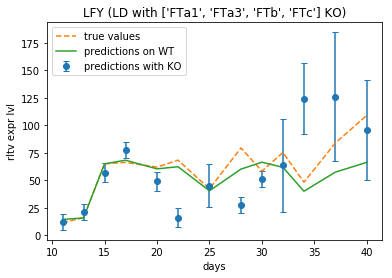

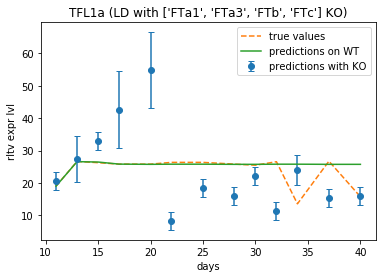

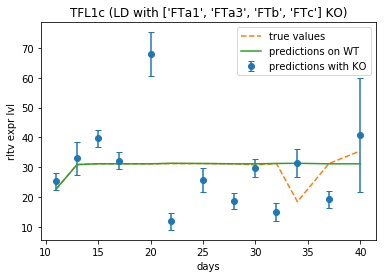

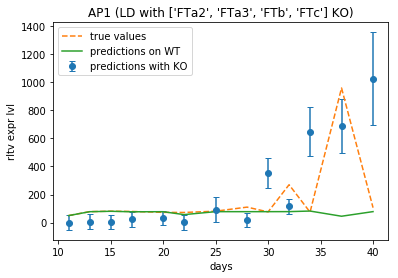

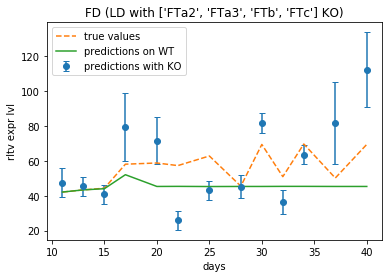

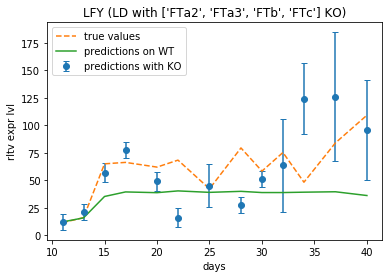

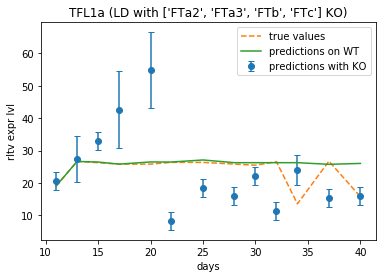

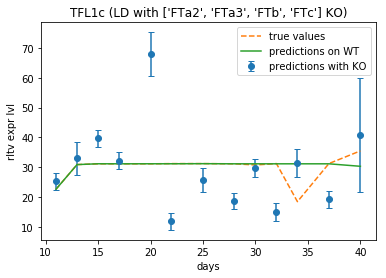

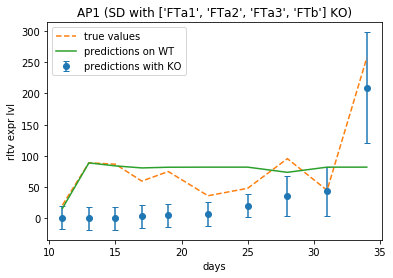

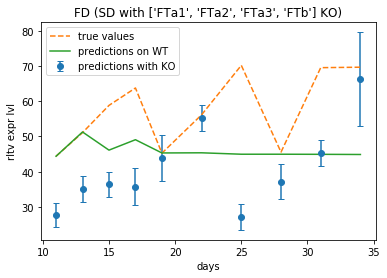

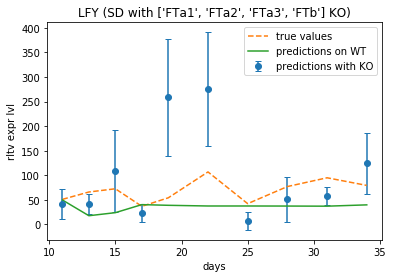

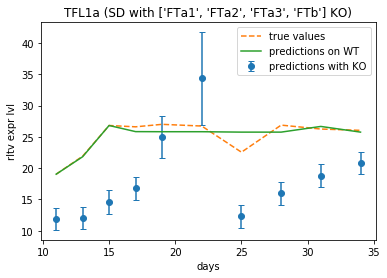

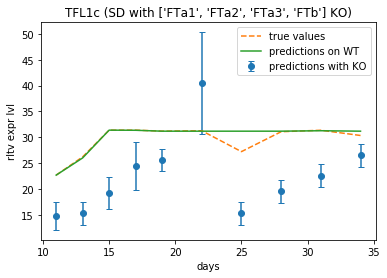

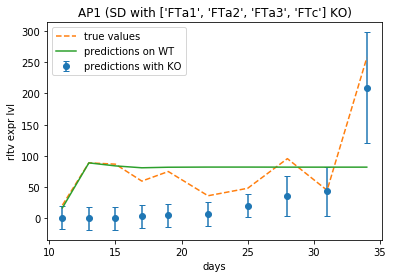

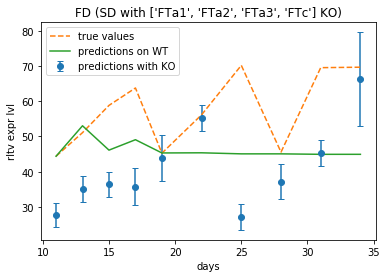

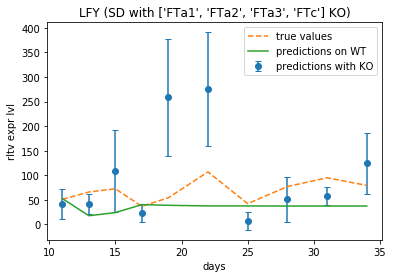

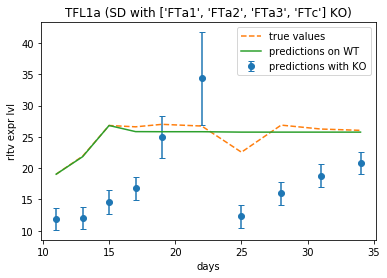

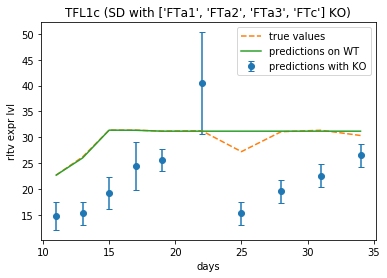

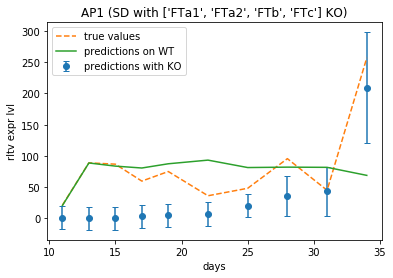

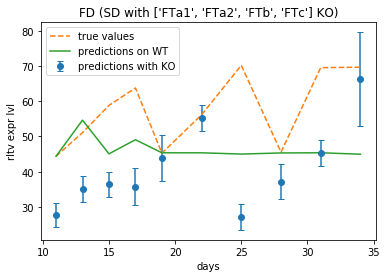

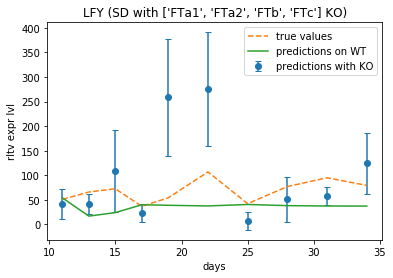

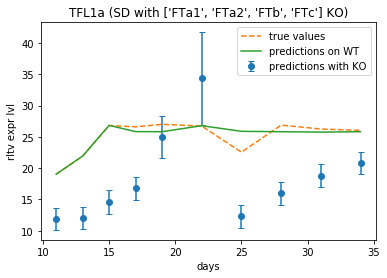

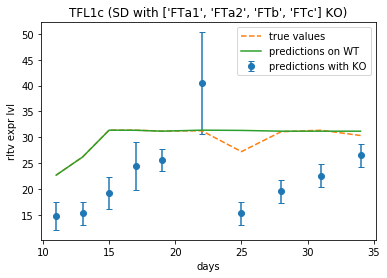

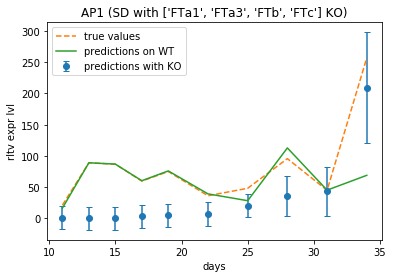

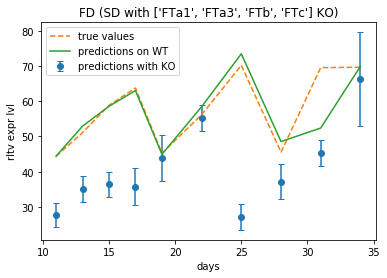

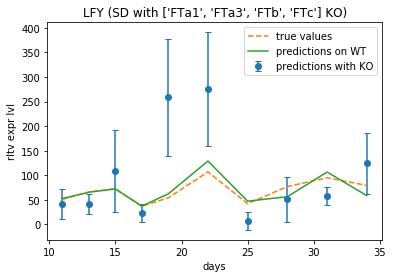

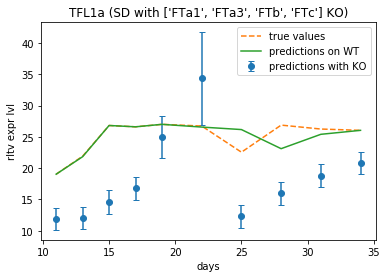

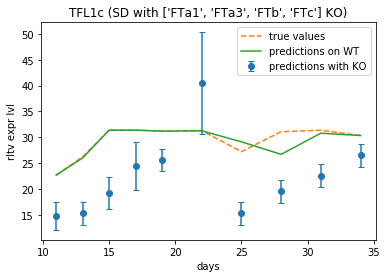

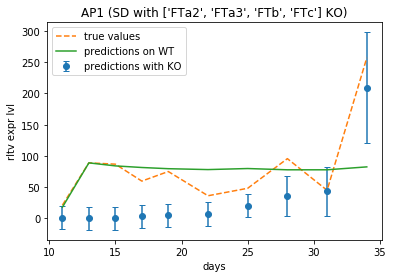

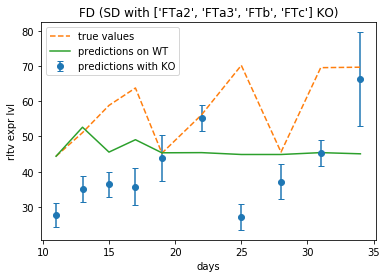

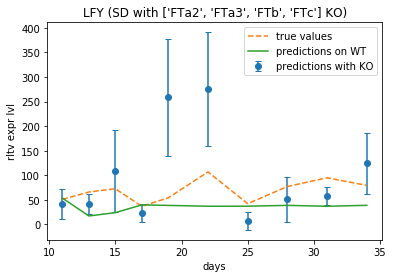

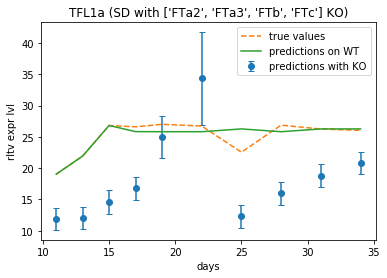

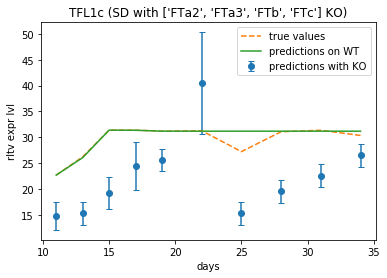

In [22]:
for ko_genes in KO_iterations:
    for cond in conditions:
        for ko_name in ko_genes:
                            
            if type(ko_name) == type((1,)):
                ko_name = list(ko_name)
            
            X_ko = X_real[cond].copy()
            X_ko = X_ko.drop('days', axis = 1)
            
            pred_ko = pd.DataFrame(columns=targets)
            
            for i in range(len(X_ko)):
                X_ko[ko_name] = 0
                current_predictions = predict(X_ko.loc[[i]])
                pred_ko = pred_ko.append(current_predictions, ignore_index = True)
                
                if i < len(X_ko) - 1:
                    X_ko[targets] = pred_ko.loc[[i]].values[0]
                
            time_long_plot_ko(Y_real[cond], predictions_real[cond], pred_ko, KO_gene=ko_name, condition=cond)
            
            column = str(ko_name)
            
            # AUCs table:
            days_axis = Y_real[cond]['days']
            for i in range(5):
                current_target = targets[i] + '_' + cond
                AUC.loc[current_target, 'WT'] = auc(days_axis, predictions_real[cond].iloc[:, i])
                AUC.loc[current_target, column] = auc(days_axis, pred_ko.iloc[:, i])

In [ ]:
X_ko

In [68]:
AUC.T

AP1_LD        FD_LD       LFY_LD  \
WT                               5361.892329  1626.137807  1792.346301   
AP1                              6401.913175  1581.409831  1688.580185   
FD                               5235.489778  1581.409831  2269.987328   
LFY                              4993.319308  1187.610745  1871.679772   
TFL1a                            7153.181557  1581.409831  2014.817752   
TFL1c                            8902.233801  1581.409831  2400.291380   
FTa1                             6398.402758  1581.409831  1846.849127   
FTa2                             6462.529730  1581.409831  1645.075649   
FTa3                             2479.708516  1581.409831  1764.149195   
FTb                              6881.820291  1581.409831  1931.285994   
FTc                              6415.405601  1581.409831  1893.892660   
['FTa1', 'FTa2']                 6458.244076  1581.409831  1657.380069   
['FTa1', 'FTa3']                 2290.153340  1581.409831  1716.987517   
['FTa1', 'FTb']                  6937.289300  1581.409831  1902.807963   
['FTa1', 'FTc']                  6411.895184  1581.409831  1868.184325   
['FTa2', 'FTa3']                 2489.225311  1581.409831  1525.675254   
['FTa2', 'FTb']                  6907.949345  1581.409831  1607.346004   
['FTa2', 'FTc']                  6475.912101  1581.409831  1645.075649   
['FTa3', 'FTb']                  2128.148068  1581.409831  1807.268359   
['FTa3', 'FTc']                  2486.155527  1581.409831  1776.052434   
['FTb', 'FTc']                   6898.881387  1581.409831  1952.628895   
['FTa1', 'FTa2', 'FTa3']         2300.958356  1581.409831  1530.198891   
['FTa1', 'FTa2', 'FTb']          6962.002848  1581.409831  1624.545061   
['FTa1', 'FTa2', 'FTc']          6471.626447  1581.409831  1657.380069   
['FTa1', 'FTa3', 'FTb']          2032.305024  1581.409831  1759.624381   
['FTa1', 'FTa3', 'FTc']          2296.966174  1581.409831  1728.330759   
['FTa1', 'FTb', 'FTc']           6954.350396  1581.409831  1923.075608   
['FTa2', 'FTa3', 'FTb']          2127.637349  1581.409831  1478.866300   
['FTa2', 'FTa3', 'FTc']          2495.672322  1581.409831  1525.675254   
['FTa2', 'FTb', 'FTc']           6924.900385  1581.409831  1607.313772   
['FTa3', 'FTb', 'FTc']           2147.999987  1581.409831  1819.328329   
['FTa1', 'FTa2', 'FTa3', 'FTb']  2040.850765  1581.409831  1488.076478   
['FTa1', 'FTa2', 'FTa3', 'FTc']  2307.771189  1581.409831  1530.198891   
['FTa1', 'FTa2', 'FTb', 'FTc']   6978.953889  1581.409831  1624.520864   
['FTa1', 'FTa3', 'FTb', 'FTc']   2050.971514  1581.409831  1770.782316   
['FTa2', 'FTa3', 'FTb', 'FTc']   2147.489269  1581.409831  1478.769068   

                                   TFL1a_LD    TFL1c_LD       AP1_SD  \
WT                               705.165949  869.784386  1738.772144   
AP1                              564.837581  663.044652   591.696915   
FD                               602.722966  778.150417   560.848179   
LFY                              602.722966  778.150417   805.617257   
TFL1a                            602.722966  778.150417   709.590073   
TFL1c                            602.722966  778.150417   742.707888   
FTa1                             602.722966  778.150417   544.765859   
FTa2                             602.722966  778.150417   744.424548   
FTa3                             602.722966  778.150417   580.663388   
FTb                              602.722966  778.150417   593.098089   
FTc                              602.722966  778.150417   591.597622   
['FTa1', 'FTa2']                 602.722966  778.150417   702.463515   
['FTa1', 'FTa3']                 602.722966  778.150417   528.856942   
['FTa1', 'FTb']                  602.722966  778.150417   545.573746   
['FTa1', 'FTc']                  602.722966  778.150417   546.746220   
['FTa2', 'FTa3']                 602.722966  778.150417   709.667189   
['FTa2', 'FTb']                  602.722966  778.150417   748.252225   
['F

# FT dynamics

In [ ]:
FTs

In [ ]:
X_real['LD']

In [ ]:
for f in FTs:
    plt.plot(X_real['LD'].days, X_real['LD'][f], '-o')
    plt.legend(FTs)

In [ ]:
plt.plot(X_real['LD'].days, X_real['LD']['A'], '-o')
plt.plot(X_real['LD'].days, X_real['LD']['FTa2'], '-o')
plt.legend(['LFY', 'FTa2'])

# AUCs

In [ ]:
# AUC = pd.read_csv('results/AUCs.csv', index_col = 0, sep=';')

In [78]:
AUC.T

AP1_LD        FD_LD       LFY_LD  \
WT                               5361.892329  1626.137807  1792.346301   
AP1                              6401.913175  1581.409831  1688.580185   
FD                               5235.489778  1581.409831  2269.987328   
LFY                              4993.319308  1187.610745  1871.679772   
TFL1a                            7153.181557  1581.409831  2014.817752   
TFL1c                            8902.233801  1581.409831  2400.291380   
FTa1                             6398.402758  1581.409831  1846.849127   
FTa2                             6462.529730  1581.409831  1645.075649   
FTa3                             2479.708516  1581.409831  1764.149195   
FTb                              6881.820291  1581.409831  1931.285994   
FTc                              6415.405601  1581.409831  1893.892660   
['FTa1', 'FTa2']                 6458.244076  1581.409831  1657.380069   
['FTa1', 'FTa3']                 2290.153340  1581.409831  1716.987517   
['FTa1', 'FTb']                  6937.289300  1581.409831  1902.807963   
['FTa1', 'FTc']                  6411.895184  1581.409831  1868.184325   
['FTa2', 'FTa3']                 2489.225311  1581.409831  1525.675254   
['FTa2', 'FTb']                  6907.949345  1581.409831  1607.346004   
['FTa2', 'FTc']                  6475.912101  1581.409831  1645.075649   
['FTa3', 'FTb']                  2128.148068  1581.409831  1807.268359   
['FTa3', 'FTc']                  2486.155527  1581.409831  1776.052434   
['FTb', 'FTc']                   6898.881387  1581.409831  1952.628895   
['FTa1', 'FTa2', 'FTa3']         2300.958356  1581.409831  1530.198891   
['FTa1', 'FTa2', 'FTb']          6962.002848  1581.409831  1624.545061   
['FTa1', 'FTa2', 'FTc']          6471.626447  1581.409831  1657.380069   
['FTa1', 'FTa3', 'FTb']          2032.305024  1581.409831  1759.624381   
['FTa1', 'FTa3', 'FTc']          2296.966174  1581.409831  1728.330759   
['FTa1', 'FTb', 'FTc']           6954.350396  1581.409831  1923.075608   
['FTa2', 'FTa3', 'FTb']          2127.637349  1581.409831  1478.866300   
['FTa2', 'FTa3', 'FTc']          2495.672322  1581.409831  1525.675254   
['FTa2', 'FTb', 'FTc']           6924.900385  1581.409831  1607.313772   
['FTa3', 'FTb', 'FTc']           2147.999987  1581.409831  1819.328329   
['FTa1', 'FTa2', 'FTa3', 'FTb']  2040.850765  1581.409831  1488.076478   
['FTa1', 'FTa2', 'FTa3', 'FTc']  2307.771189  1581.409831  1530.198891   
['FTa1', 'FTa2', 'FTb', 'FTc']   6978.953889  1581.409831  1624.520864   
['FTa1', 'FTa3', 'FTb', 'FTc']   2050.971514  1581.409831  1770.782316   
['FTa2', 'FTa3', 'FTb', 'FTc']   2147.489269  1581.409831  1478.769068   

                                   TFL1a_LD    TFL1c_LD       AP1_SD  \
WT                               705.165949  869.784386  1738.772144   
AP1                              564.837581  663.044652   591.696915   
FD                               602.722966  778.150417   560.848179   
LFY                              602.722966  778.150417   805.617257   
TFL1a                            602.722966  778.150417   709.590073   
TFL1c                            602.722966  778.150417   742.707888   
FTa1                             602.722966  778.150417   544.765859   
FTa2                             602.722966  778.150417   744.424548   
FTa3                             602.722966  778.150417   580.663388   
FTb                              602.722966  778.150417   593.098089   
FTc                              602.722966  778.150417   591.597622   
['FTa1', 'FTa2']                 602.722966  778.150417   702.463515   
['FTa1', 'FTa3']                 602.722966  778.150417   528.856942   
['FTa1', 'FTb']                  602.722966  778.150417   545.573746   
['FTa1', 'FTc']                  602.722966  778.150417   546.746220   
['FTa2', 'FTa3']                 602.722966  778.150417   709.667189   
['FTa2', 'FTb']                  602.722966  778.150417   748.252225   
['F

In [24]:
AUC_norm = AUC.T / AUC.WT

In [25]:
for col in AUC_norm.columns:
    AUC_norm.loc[col[:-3], col] = 1.

## Heatmap

In [26]:
def my_heatmap(data, figsize = (15, 5), format='svg'):
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(data, robust = True, center = 1, cmap='RdBu_r')
    plt.xlabel('KO genes')
    plt.ylabel('AUC relative to WT AUC')
    
    fig_path = results_path + 'dynamic/'

    if not os.path.exists(fig_path):
        os.makedirs(fig_path)

    plt.savefig(fig_path + f'Heatmap.{format}', bbox_inches='tight', format=format, dpi=300)

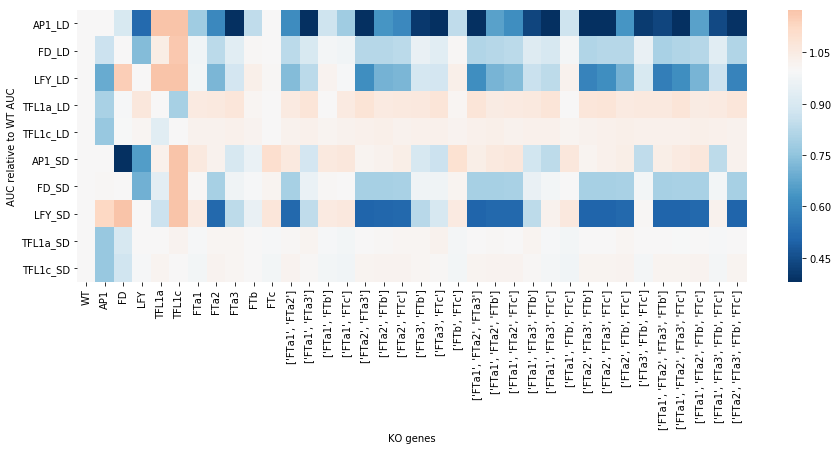

In [27]:
my_heatmap(AUC_norm.T)

## Barplots

In [28]:
def AUC_barplots(dataframe, format='svg'):
    for index in dataframe.index:
        df = dataframe.drop([index[:-3], 'WT'], axis=1)
        df.loc[index] = df.loc[index] / dataframe.loc[index, 'WT']
        col = df.columns
        
        plt.figure(figsize=(20,10))

        myplot = sns.barplot(y = index, x = col, data = df.T)
        plt.xticks(rotation=60)
        plt.xlabel('KO genes')
        plt.ylabel('KO/WT transcription level')
        plt.title(index.replace('_', ' '))
        myplot.axes.axhline(1, dashes=(5, 1))
        
        fig_path = results_path + 'dynamic/barplots/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{index}.{format}', bbox_inches='tight', format=format, dpi=300)
        plt.show()

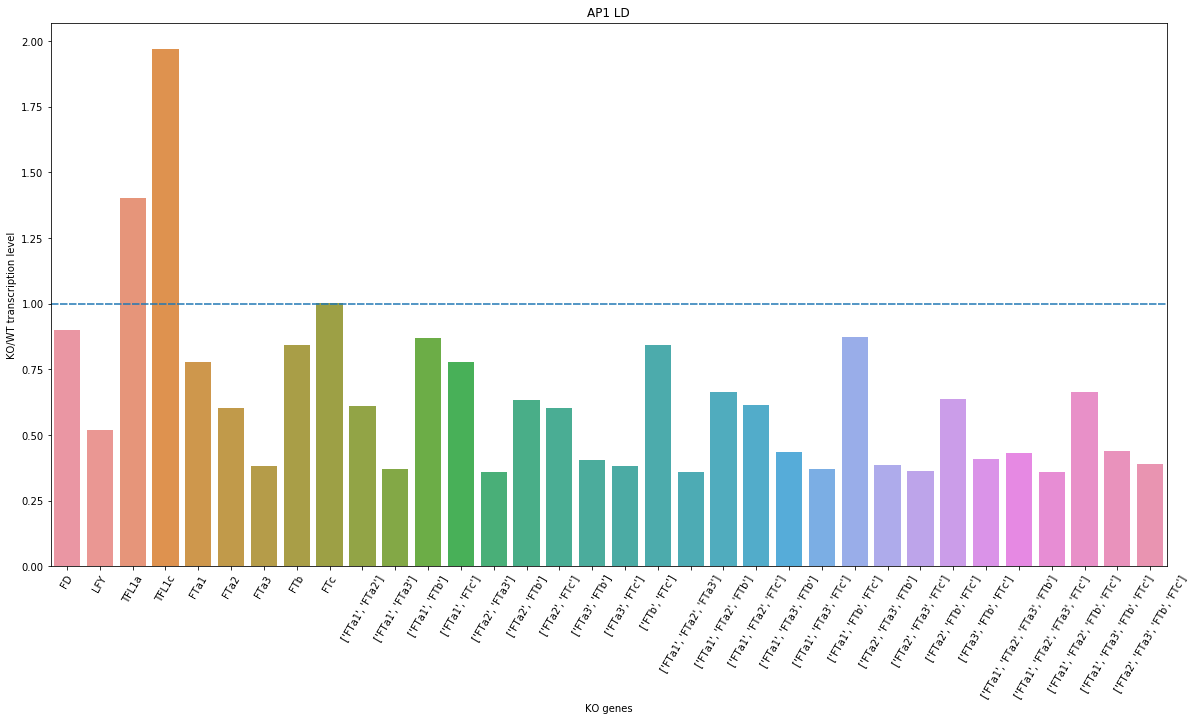

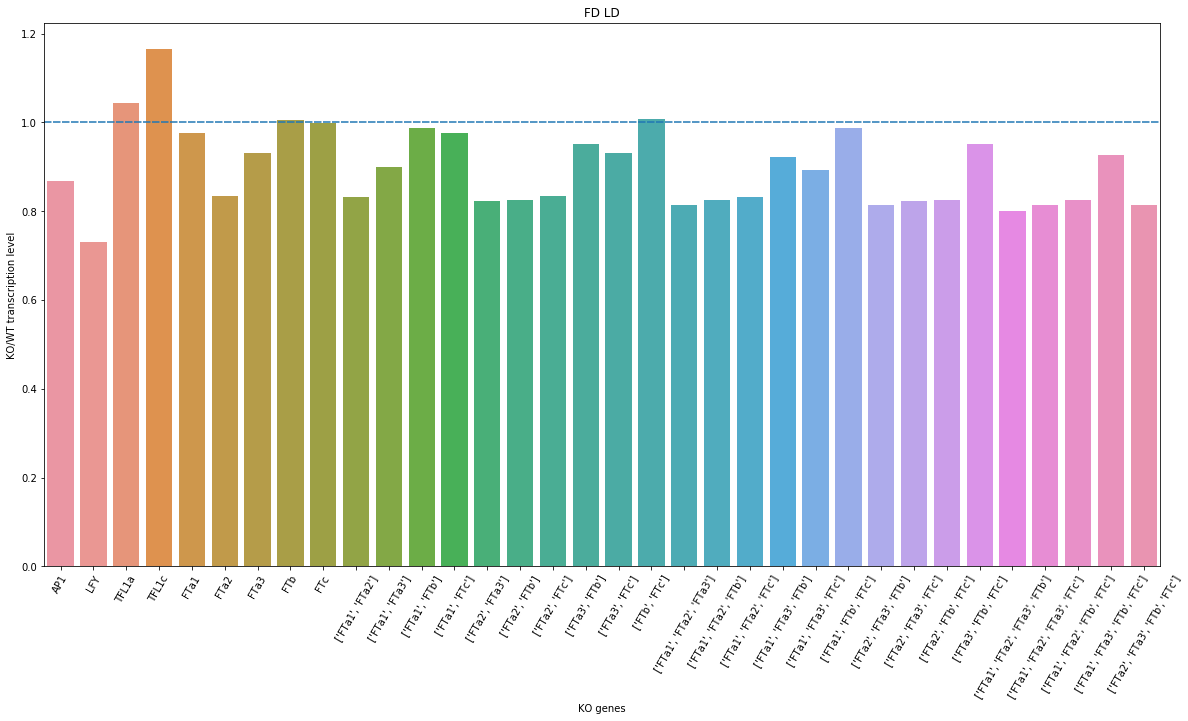

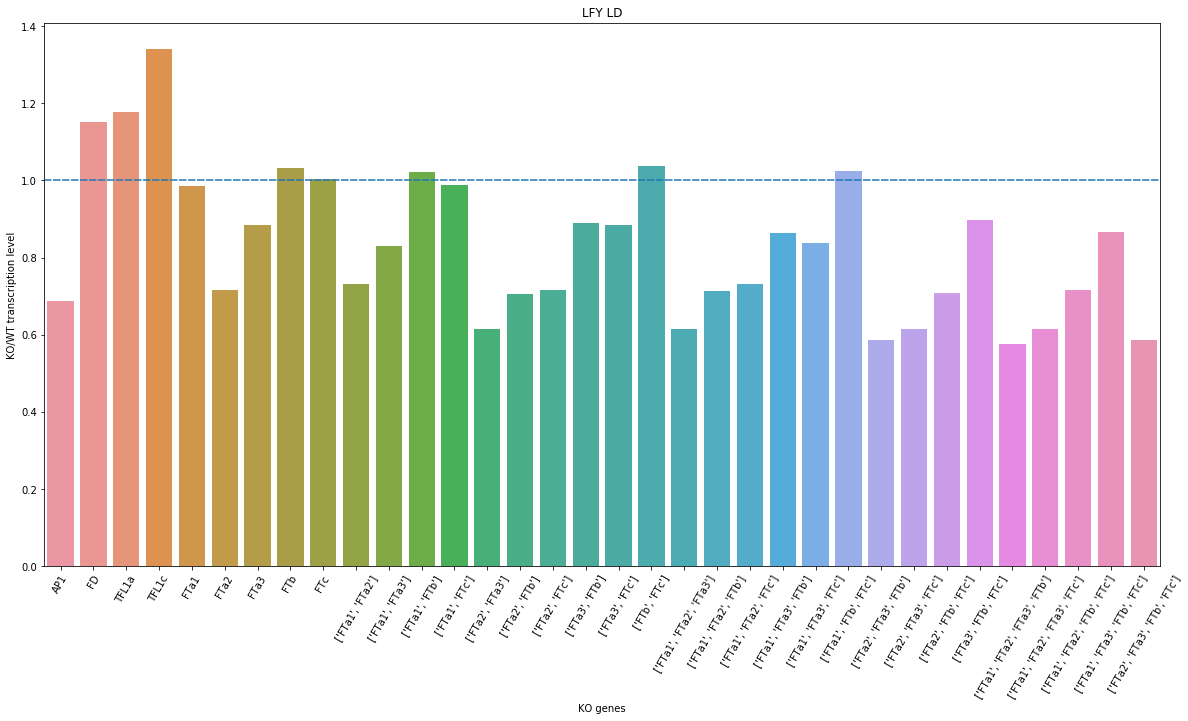

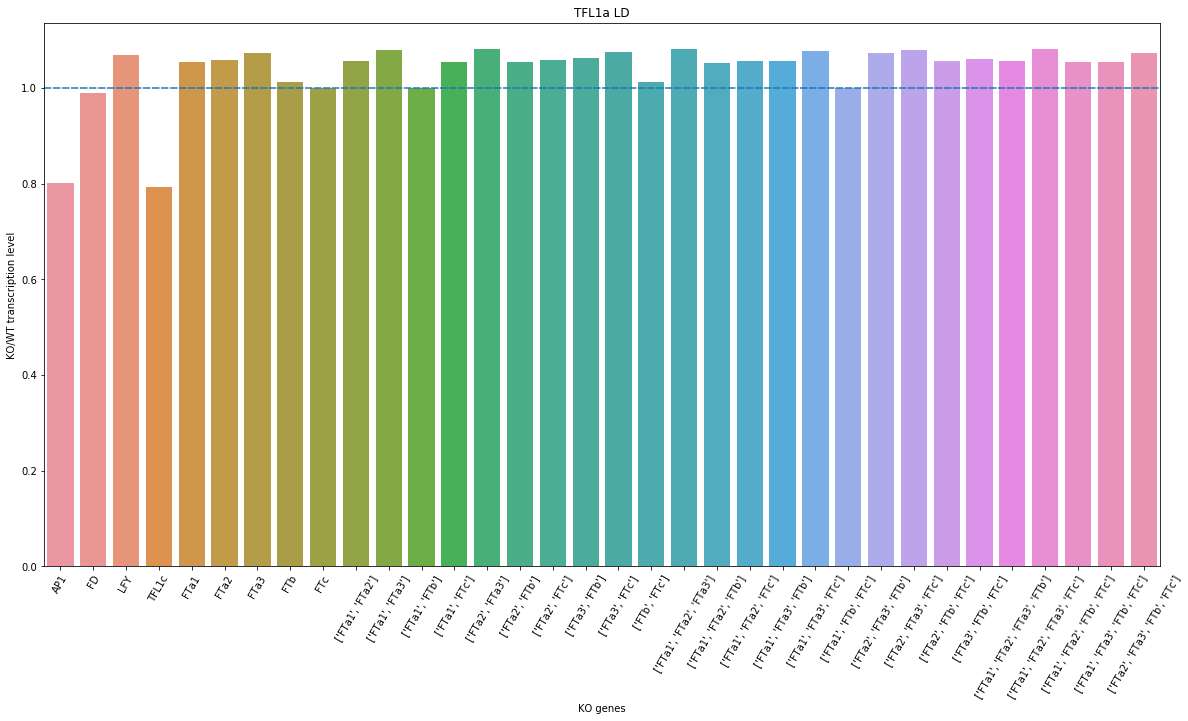

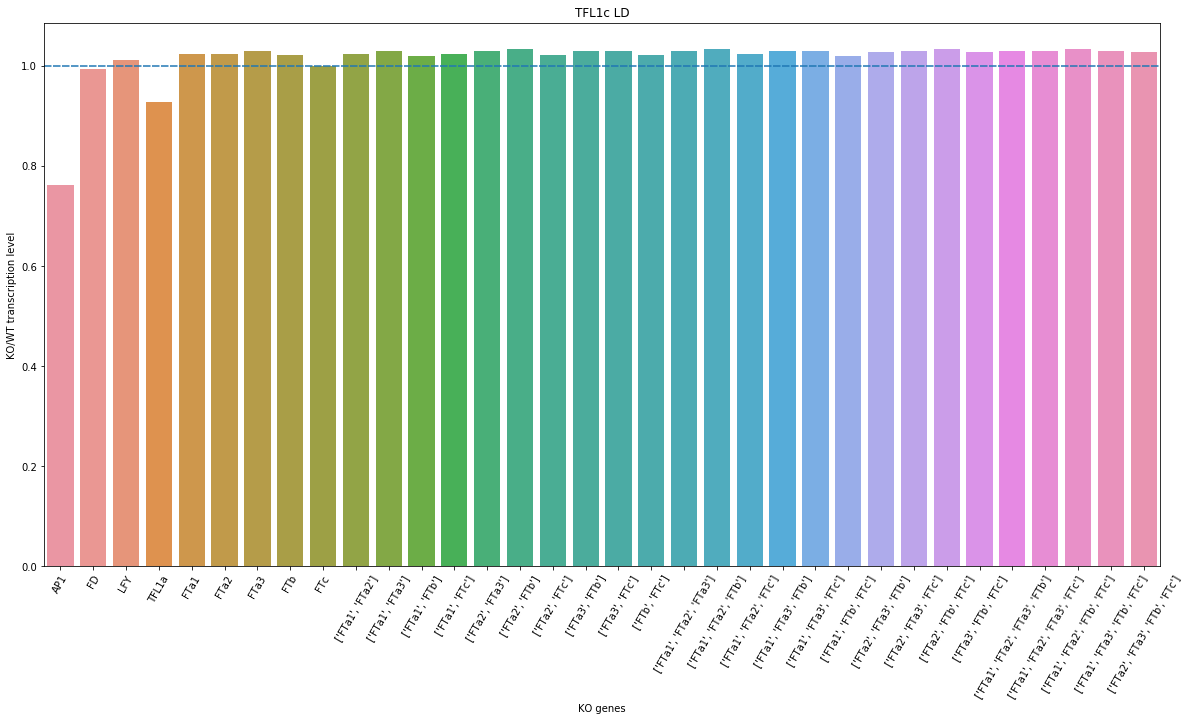

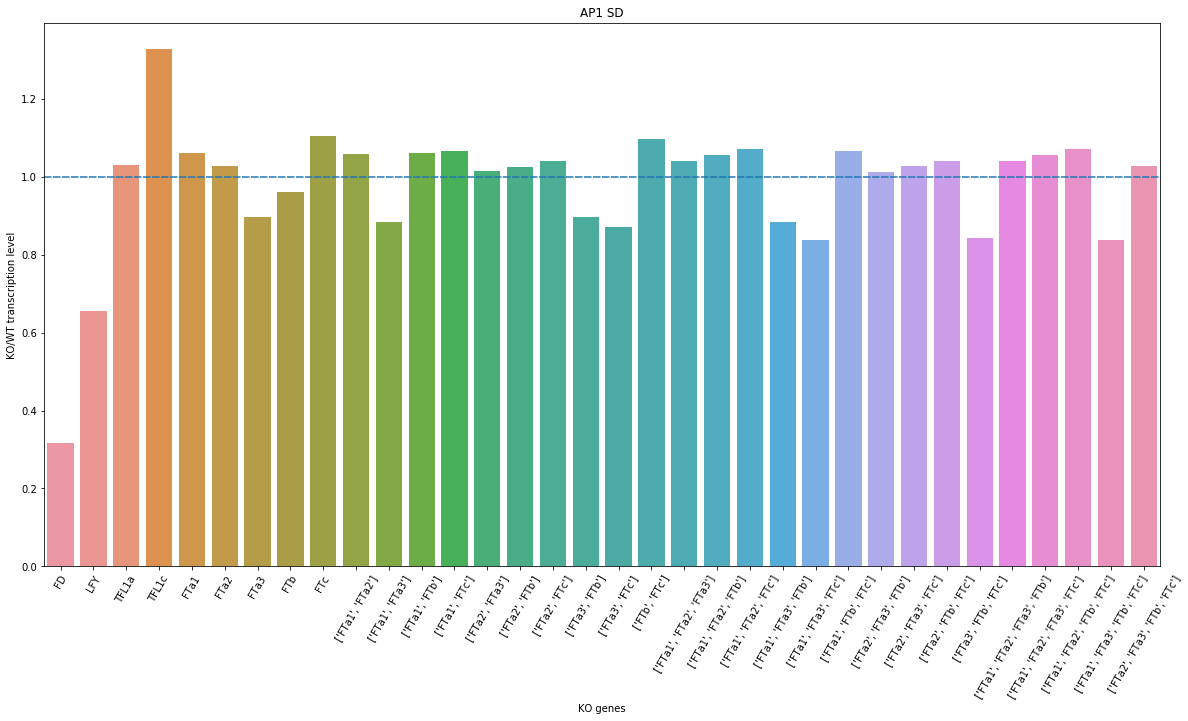

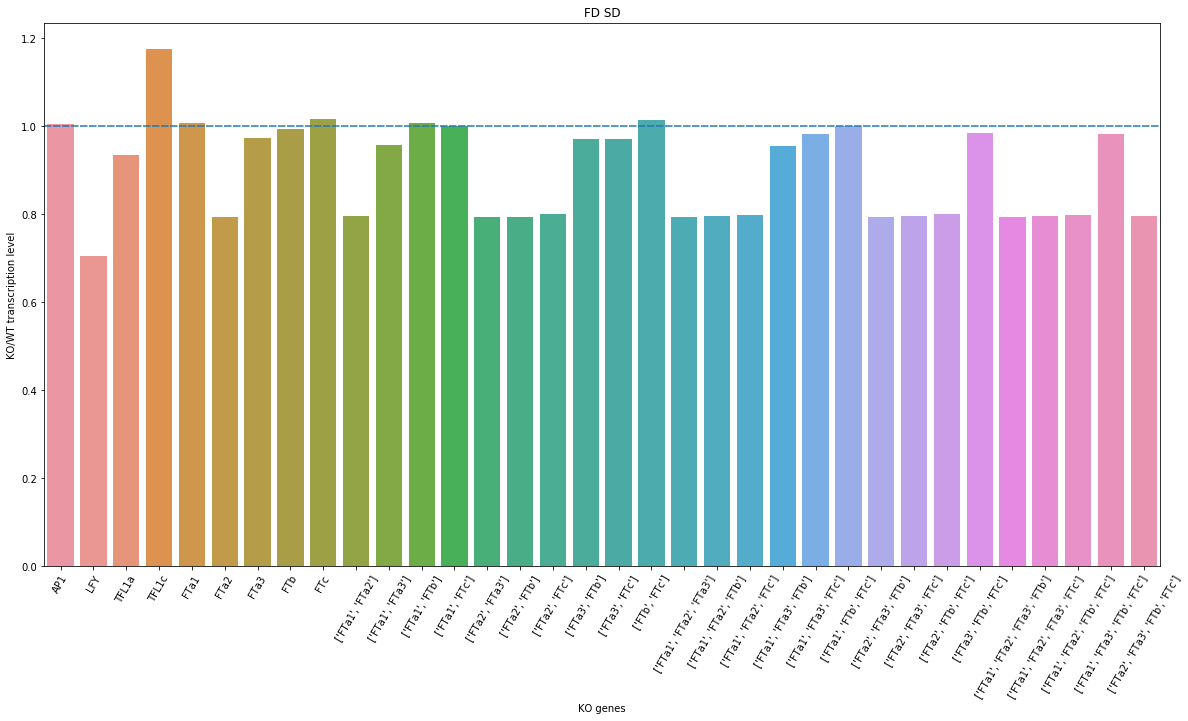

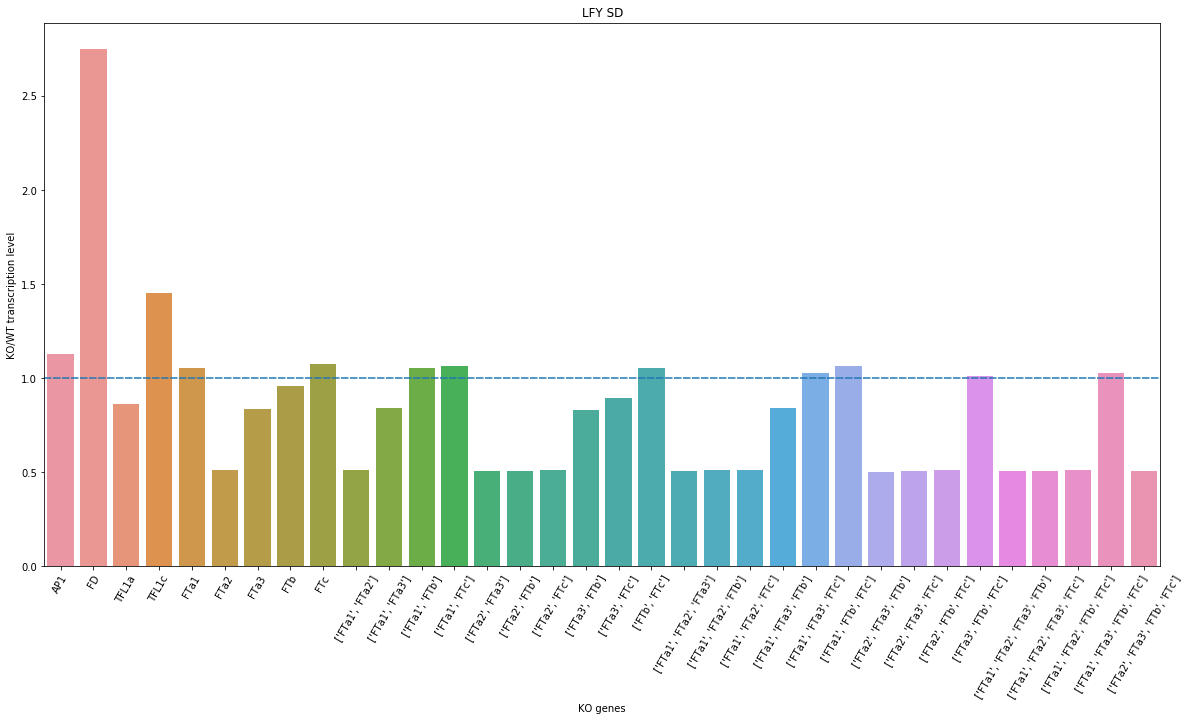

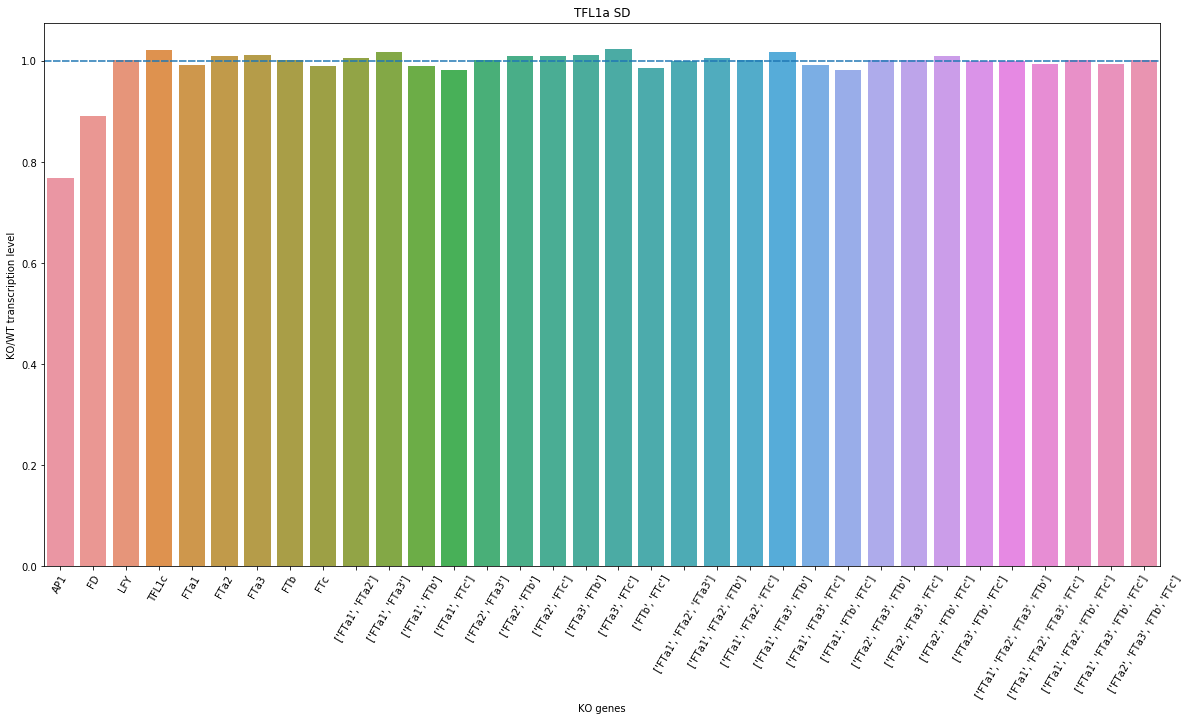

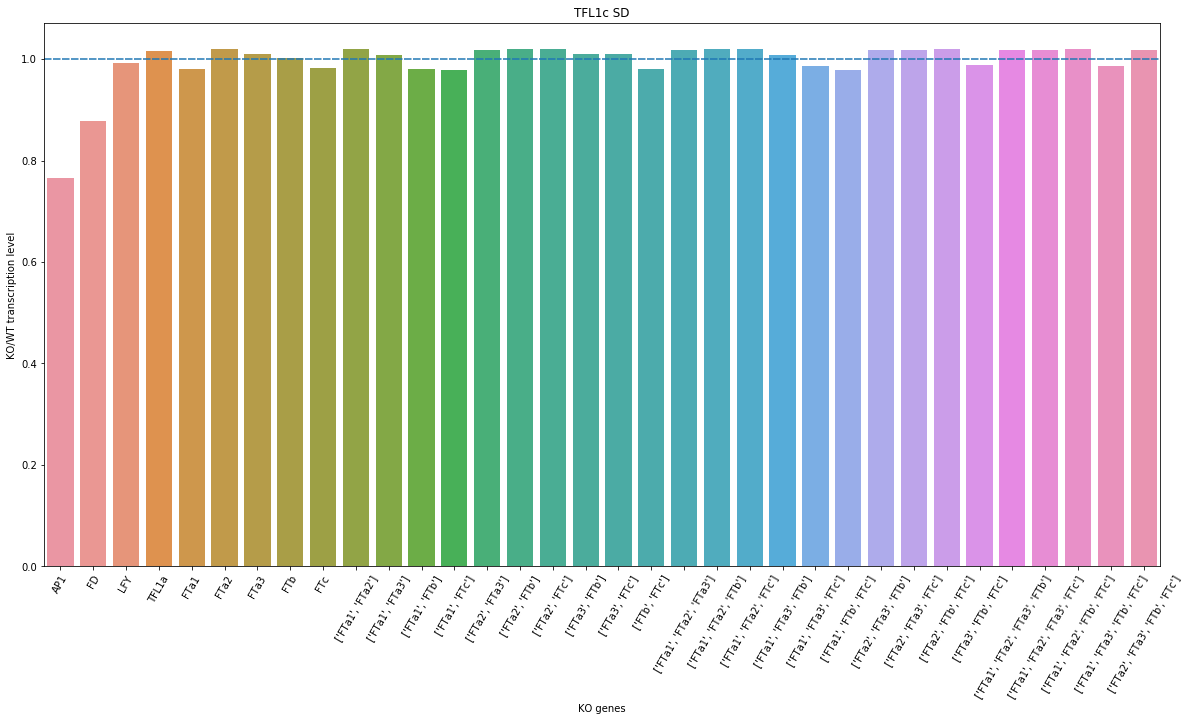

In [29]:
AUC_barplots(AUC)

In [ ]:
for f in ['FTb', 'FTa1', 'FTa3', 'FTa1_FTb']:
    myplot = sns.barplot(y = (AUC.T.loc[f,]/AUC.T.loc['WT',]).tolist(), x = AUC.T.columns)
    plt.xticks(rotation=60)
    myplot.axes.axhline(1, dashes=(5, 1))
    plt.title(f)
    plt.show()

# Save and load the model

In [23]:
dill.dump_session('cache/Reduced_model.db')

In [3]:
dill.load_session('cache/Reduced_model.db')

# Some trash

In [ ]:
# import torch

In [ ]:
# model_save_name = 'RF_regressor.pt'
# # path = F"/content/gdrive/My Drive/{model_save_name}" 
# model_path = data_path + model_save_name
# torch.save(total_model.state_dict(), model_path)

In [ ]:
def logging(description, out):
    string = str(description) + ': ' + str(out)
    with open('results/log.txt', 'a') as out_file:
        out_file.write(string + '\n')
    print(string)

In [ ]:
# def clear_log():
#     with open('results/NN/NN_log.txt', 'w') as out_file:
#         out_file.write('log file have been cleared ' + str(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S')))